###Overview

This notebook trains a Mamba model for the UAV class.\
It uses only the samples taken from UAV files (training and validation).\
The model is trained on all sample durations and so we prepare a dataloader that mixes batches of different durations.\
The training class does the training while evaluating the results on the validation samples (of different lengths).\
Notes:
- The training uses an early stopping mechanism where we stop if the validation results have not improved for over "early_stopping" parameter in the configuration.
- The best model parameters are saved, along with the training history. It is possible to load and continue training for a model by configuring 'continued' to True and incrementig 'run' in the training configuration.
- A warm up training with a high learning rate is also implemented.
- Training has an 'evaluation_length' parameter for determining the part of the seuence for which we evaluate performance. I used the last 3 seconds of each sample.
- Since we have different scales between different inputs and different samples, and we want to give them all the same weight in the loss function, we use the 'scale' of the samples to normalize the predictions and lables before going into the loss function. The scale is the 'local Std' calculated for each parameter in preprocessing.
- The model parameters and the time are encoded into a string for the file saving path for identification.

### Imports and loading

In [ ]:
# imports

import io
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings

warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
import seaborn as sns
import random

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid, ReLU
from torch.nn import Linear, Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose
from torch.optim import SparseAdam, Adam, Adagrad, AdamW
from torch.optim.lr_scheduler import LinearLR, MultiStepLR

from dataclasses import dataclass
from einops import rearrange, repeat, einsum

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

#from google.colab import drive
#drive.mount('/content/drive/')
# helper files
#sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from preprocessing_utils import *
from mamba_model import *
from trajectory_dataset import prepare_mixed_dataloader

In [ ]:
#cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [3]:
subfolders = os.listdir("C:/workspace/DL/UAV_classification_with_Mamba/track_data")
subf_dict = {i: subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]: i for i in range(len(subfolders))}

### Model

In [4]:
def prepare_mixed_dataloader(all_data, batch_size, shuffle=True):
    #shuffled once inside each duration group and then batches are shuffled among durations
    all_batches = []
    for dur, (samples, samples_filenames, dt, scales) in all_data.items():
        dur_vec = [dur] * len(samples)
        if len(samples) > 0:
            data = list(zip(samples, dt, scales, dur_vec))
            dl = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
            for batch in dl:
                all_batches.append(batch)
    if shuffle:
        random.shuffle(all_batches)
    return all_batches

In [ ]:
# save_path = './Samples/mamba_samples_testing0_' + samples_config['subfolder'] + '_all_samples'
# with open(save_path , 'rb') as f:
#   # train_samples, test_samples, train_samples_filenames, test_samples_filenames, train_dt, test_dt, train_scales, test_scales = pickle.load(f)
#   (all_train_data, all_vel_data, all_test_data) = pickle.load(f)

In [ ]:
# train_batches = prepare_mixed_dataloader(all_train_data, 2)
# sample, dt, scale = train_batches[0]

# print(sample.shape)
# print(dt.shape)
# print(scale.shape)

torch.Size([2, 750, 8])
torch.Size([2, 750])
torch.Size([2, 8])


### Training class

In [16]:
class Training(object):

    def __init__(self, model, config):
        self.config = config
        self.sample_durations = config['sample_durations']
        self.evaluation_durations = config['eval_sample_durations']
        self.device = config['device']
        self.model = model.to(self.config['device'])
        self.model_path = config['model_path']
        lr = config['optimizer_parameter']['lr']
        config['optimizer_parameter']['lr'] = 0.1
        self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
        self.scheduler = MultiStepLR(self.optimizer, milestones=[10], gamma=lr / 0.1)
        # self.scheduler = LinearLR(self.optimizer, start_factor=0.05/lr, end_factor=1, total_iters=20)
        self.criterion = config['criterion'].to(self.device)
        self.epoch_offset = 0
        self.training_time = 0
        self.evaluation_length = int(config['evaluation_time'] / config['delta'])

    def train(self, train_data, eval_data):
        self.dl_train = train_data
        self.dl_eval = eval_data
        self.eval_history = {d: [] for d in self.evaluation_durations}
        self.eval_loss_history = []
        self.train_loss_history = []
        self.best_results = {d: None for d in self.evaluation_durations}

        if self.config['continued']:
            self.load_model()  #loads model state from a previous run

        epochs_without_improvement = 0
        best_loss = None
        train_start = time()

        for epoch in range(self.epoch_offset, self.config['n_epochs'] + self.epoch_offset):
            # train
            self.train_epoch()
            #evaluate
            self.evaluate_epoch(self.dl_eval)
            self.scheduler.step()
            self.eval_loss_history.append(self.epoch_eval_loss / len(self.dl_eval))
            for d in self.evaluation_durations:
                if len(self.eval_results[
                           d]) > 0:  # this in case some class doesn't have test samples that are long enough for this d
                    self.eval_history[d].append(sum(self.eval_results[d]) / len(self.eval_results[d]))
                else:
                    self.eval_history[d].append(0)

            if self.config['verbose']:
                print(
                    f'epoch {epoch}: train loss = {self.train_loss_history[-1]}, eval loss = {self.eval_loss_history[-1]}')
            #check for early stopping
            if not best_loss or self.eval_history[10][-1] < best_loss:
                best_loss = self.eval_history[10][-1]
                best_train_loss = self.train_loss_history[-1]
                best_eval_loss = self.eval_loss_history[-1]
                self.best_results = {d: self.eval_history[d][-1] for d in self.evaluation_durations}

                epochs_without_improvement = 0
                #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
                best_model = copy.deepcopy(self.model.state_dict())
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement == self.config['early_stopping']:
                if self.config['verbose']:
                    print('\nEarly stoping after {} epochs. eval loss did not imporve for more than {} epochs'.format(
                        epoch, self.config['early_stopping']))
                break

        self.training_time = self.training_time + time() - train_start

        # load best model and best performance and save
        self.model.load_state_dict(best_model)
        losslogger = {'train_loss': self.train_loss_history, 'eval_loss': self.eval_loss_history,
                      'eval_history': self.eval_history}
        state = {'epoch': epoch - epochs_without_improvement + 1, 'state_dict': best_model,
                 'optimizer': self.optimizer.state_dict(), 'losslogger': losslogger,
                 'training_time': self.training_time}
        torch.save(state, self.model_path)

        if self.config['verbose']:
            print('\nFinished Training:')
            print('Best metrics are:')
            print(f'Best loss = {best_loss}')
            print(f'Best train loss = {best_train_loss}')
            print(f'Best eval loss = {best_eval_loss}')
            # print('Evaluation LogLoss = '.format(best_loss))
            for d, best in self.best_results.items():
                print(f'Best {d}sec eval = {best}')

            # print(f'Best 5sec eval = {best_5sec}')
            # print(f'Best 10sec eval= {best_10sec}')
            # print(f'Best 30sec eval= {best_30sec}')
            # print(f'Best 60sec eval= {best_60sec}')

    def train_epoch(self):
        self.epoch_train_loss = 0
        self.model.train()  # train mode
        for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
            self.train_batch(batch)
        self.train_loss_history.append(self.epoch_train_loss / len(self.dl_train))

    def train_batch(self, batch):
        data, dt, scale, dur = batch
        # Send tensors to GPU
        samples = data[:, :-1, :]
        labels = data[:, 1:, :]
        samples = samples.to(self.device)
        labels = labels.to(self.device)

        dt = dt[:, :-1].to(self.device)
        scale = scale.to(self.device)
        predictions = self.model(samples, dt)  #.type(torch.float64)#.type(torch.DoubleTensor)
        print("Labels:")
        print(labels)
        print("Samples:")
        print(samples)
        scaled_labels = einsum(labels, 1 / scale, 'b l d, b d -> b l d')
        print("Scaled labels:")
        print(scaled_labels)
        scaled_predictions = einsum(predictions, 1 / scale, 'b l d, b d -> b l d')
        print("Sclaed pred:")
        print(scaled_predictions)
        loss = self.criterion(scaled_predictions, scaled_labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epoch_train_loss += loss.item()

    def evaluate_epoch(self, dl_eval):
        self.eval_results = {d: [] for d in self.evaluation_durations}
        self.epoch_eval_loss = 0

        self.model.eval()  #evaluation mode
        with torch.no_grad():
            for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
                self.eval_batch(batch)

    def eval_batch(self, batch):
        data, dt, scale, dur = batch
        # Send tensors to GPU
        samples = data[:, :-1, :]
        labels = data[:, 1:, :]
        samples = samples.to(self.device)
        labels = labels.to(self.device)
        dt = dt[:, :-1].to(self.device)
        scale = scale.to(self.device)

        predictions = self.model(samples, dt)  #.type(torch.float64)#.type(torch.DoubleTensor)

        scaled_labels = einsum(labels, 1 / scale, 'b l d, b d -> b l d')
        scaled_predictions = einsum(predictions, 1 / scale, 'b l d, b d -> b l d')
        criterion = nn.MSELoss(reduction='none').to(self.device)
        eval_loss = criterion(scaled_predictions, scaled_labels)
        self.eval_results[int(dur[0])].append((eval_loss[:, -self.evaluation_length:, :].mean()).cpu())
        self.epoch_eval_loss += eval_loss.mean().item()

    def load_model(self):
        prev_model = self.model_path[:-1] + str(self.config['run'] - 1)
        if os.path.exists(prev_model) and not os.path.exists(self.model_path):
            state = torch.load(prev_model)
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            self.epoch_offset = state['epoch']
            self.train_loss_history = state['losslogger']['train_loss']
            self.eval_loss_history = state['losslogger']['eval_loss']
            self.eval_history = state['losslogger']['eval_history']
            self.training_time = state['training_time']
        else:
            raise ValueError('No previous model found')

In [6]:
def plot_training_summary(training_model):
    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(epochs, training_model.train_loss_history, 'r', label='train loss')
    ax1.plot(epochs, training_model.eval_loss_history, 'orange', label='eval loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    palette = plt.get_cmap('tab20')
    colors = [palette(i) for i in range(len(training_model.evaluation_durations))]
    for d, color in zip(training_model.evaluation_durations, colors):
        plt.yscale("log")
        ax2.plot(epochs, training_model.eval_history[d], color=color, label=d)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Error')
    ax2.legend()

In [7]:
def conf2str(mamba_config, training_config):
    #used to encode the run parameters to a string for identification
    conf_str = 'dm' + str(mamba_config['d_model']) \
               + 'nl' + str(mamba_config['n_layer']) \
               + 'ds' + str(mamba_config['d_state']) \
               + 'dc' + str(mamba_config['d_conv']) \
               + 'rs' + str(mamba_config['model_random_state']) \
               + 'bs' + str(training_config['batch_size']) \
               + 'op' + training_config['optimizer_name'] \
               + 'lr' + str(training_config['optimizer_parameter']['lr']) \
               + 'r' + str(training_config['run'])

    return conf_str

## Experiments
The blocks below execute training.\
We need to:
1. Set the samples configuration
2. Set the Mamba model configuration parameters
3. Create a Mamba model according to the parameters
4. Set the training configuration parameters
5. Init a training instance
6. Prepare dataloaders for the training and validation sets
7. Train
8. Record all the results with the configurations to a pandas dataframe. Save it.
9. Plot the training summary

In [8]:
samples_config = {
    'subfolder': 'uav',
    'delta': 0.04,
    'sample_durations': [5, 10, 30, 60],
    'eval_sample_durations': [5, 10, 15, 20, 25, 30],
    'sample_duration': 10,
    'skip_duration': 15,
    'min_samples': 10
}

In [ ]:
# Load data from JSON files using PyTorch DataLoader
data_dir = './data'  # Update this path to your data directory

# Note: all_train_batches and all_val_batches will be created in the training loop
# with the correct batch size. This is just for compatibility.
all_train_data = {}  # Not used, but kept for compatibility
all_val_data = {}   # Not used, but kept for compatibility
all_test_data = {}  # Not used, but kept for compatibility

# Extract test filenames for the record (minimal compatibility)
from trajectory_dataset import TrajectoryDataset
test_dataset = TrajectoryDataset(
    data_dir=data_dir,
    sample_duration=samples_config['sample_durations'][0],
    split='test',
    delta=samples_config['delta']
)
if len(test_dataset) > 0:
    test_samples, test_dt, test_scales, _ = test_dataset[0]
    test_filenames = [str(test_dataset.trajectory_files[0])]
else:
    test_samples, test_filenames, test_dt, test_scales = [], [], [], []

print(f"Data directory: {data_dir}")
print(f"Test dataset size: {len(test_dataset)}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
record_columns = ['datetime', 'Best Result @5', 'Best Result @10', 'Best Result @20', 'Learning Rate', 'Batch Size',
                  'Layers', 'd_state', 'Model Path', 'Test Files', 'Mamba Config', 'Training Config',
                  'Train Loss History', 'Evaluation Loss History', 'Eval History', 'Best Results']
exp_record = pd.DataFrame(columns=record_columns)

In [ ]:
# learning_rates = [0.1, 0.05]
learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    date_time_ = str(date_time).replace("/", "_")
    mamba_config = {'d_model': 2, 'n_layer': 2, 'd_state': 32, 'expand': 2, 'd_conv': 4, 'model_random_state': 42}  # d_model=2 for (x,y) positions
    model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
    training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam',
                       'optimizer_parameter': {'lr': lr}, \
                       'criterion': nn.MSELoss(), 'n_epochs': 400, 'early_stopping': 20, 'evaluation_time': 3,
                       'delta': 0.04, \
                       'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30], \
                       'verbose': True, 'device': device, 'continued': False, 'run': 1}
    training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
    # for bs in batch_sizes:
    #   for l in layers:
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'],
                     mamba_config['d_conv'])
    mamba_model = Mamba(args)

    # Recreate dataloaders with correct batch size
    all_train_batches = prepare_mixed_dataloader(
        data_dir=data_dir,
        sample_durations=samples_config['sample_durations'],
        batch_size=training_config['batch_size'],
        split='train',
        shuffle=True,
        delta=samples_config['delta']
    )
    all_val_batches = prepare_mixed_dataloader(
        data_dir=data_dir,
        sample_durations=samples_config['sample_durations'],
        batch_size=training_config['batch_size'],
        split='val',
        shuffle=False,
        delta=samples_config['delta']
    )

    training_mamba = Training(mamba_model, training_config)
    training_mamba.train(all_train_batches, all_val_batches)  #end of training loads the best model

    # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
    #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
    #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
    #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
    exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]),
                                       int(training_mamba.best_results[10]), int(training_mamba.best_results[20]), \
                                       lr, training_config['batch_size'], mamba_config['n_layer'],
                                       mamba_config['d_state'], \
                                       training_config['model_path'], test_filenames, mamba_config.copy(),
                                       training_config.copy(), \
                                       training_mamba.train_loss_history, training_mamba.eval_loss_history,
                                       training_mamba.eval_history, training_mamba.best_results]
    plot_training_summary(training_mamba)
    # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
    #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

  0%|          | 0/14 [00:00<?, ?it/s]

Labels:
tensor([[[-7.0022e+01,  9.3489e+00,  2.9468e-01,  ...,  1.2919e+00,
           6.8124e-02,  3.3124e-02],
         [-7.0010e+01,  9.3512e+00,  2.9160e-01,  ...,  8.7498e-01,
           6.9967e-02,  3.2861e-02],
         [-6.9995e+01,  9.3551e+00,  3.8477e-01,  ...,  1.0369e+00,
           6.9438e-02,  3.2142e-02],
         ...,
         [-6.7266e+01,  9.1031e+00, -8.1474e-02,  ..., -3.0447e+00,
           5.9153e-02,  3.4779e-02],
         [-6.7269e+01,  9.0998e+00, -7.4926e-02,  ..., -5.2793e-03,
           6.0771e-02,  3.5099e-02],
         [-6.7270e+01,  9.0995e+00, -2.2705e-02,  ...,  1.8321e+00,
           6.5080e-02,  3.4790e-02]],

        [[-8.5375e+01,  1.1896e+01,  2.6156e-01,  ..., -1.5394e-01,
           1.1857e-01,  5.6675e-02],
         [-8.5383e+01,  1.1935e+01, -2.1143e-01,  ...,  1.1983e+01,
           1.0474e-01,  4.9882e-02],
         [-8.5382e+01,  1.1973e+01,  4.3037e-02,  ..., -3.2160e-01,
           1.0760e-01,  5.2493e-02],
         ...,
         [-8.4952

  7%|▋         | 1/14 [00:01<00:16,  1.30s/it]

Labels:
tensor([[[-6.7240e+01,  9.1215e+00,  9.5780e-02,  ..., -2.3918e+00,
           6.1336e-02,  3.8052e-02],
         [-6.7234e+01,  9.1175e+00,  1.6429e-01,  ..., -7.1361e-01,
           5.9117e-02,  3.8998e-02],
         [-6.7231e+01,  9.1179e+00,  7.0240e-02,  ...,  2.7656e+00,
           6.2982e-02,  3.8998e-02],
         ...,
         [-8.0391e+01,  8.9557e+00,  1.5065e-01,  ...,  1.8352e+00,
           5.5395e-02,  4.4183e-02],
         [-8.0369e+01,  8.9497e+00,  5.3300e-01,  ..., -2.2199e+00,
           5.1277e-02,  4.2694e-02],
         [-8.0339e+01,  8.9469e+00,  7.6624e-01,  ...,  2.0254e+00,
           4.9074e-02,  3.9380e-02]],

        [[-1.1214e+02,  1.5086e+01,  5.2835e+00,  ...,  0.0000e+00,
           1.8222e-01,  1.1798e-01],
         [-1.1195e+02,  1.5047e+01,  4.8422e+00,  ...,  7.7875e+00,
           1.3905e-01,  8.3407e-02],
         [-1.1175e+02,  1.5006e+01,  5.1200e+00,  ..., -1.4148e+00,
           1.4828e-01,  8.3407e-02],
         ...,
         [-8.1532

  7%|▋         | 1/14 [00:06<01:26,  6.64s/it]


KeyboardInterrupt: 

In [17]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results


100%|██████████| 17/17 [00:00<00:00, 18.74it/s]


epoch 0: train loss = 4262764.197916667, eval loss = 4882583.544117647


100%|██████████| 17/17 [00:00<00:00, 19.72it/s]


epoch 1: train loss = 3606588.0520833335, eval loss = 4124561.8088235296


100%|██████████| 17/17 [00:01<00:00, 13.05it/s]


epoch 2: train loss = 3024037.8020833335, eval loss = 3471548.1029411764


100%|██████████| 17/17 [00:01<00:00, 15.81it/s]


epoch 3: train loss = 2516774.921875, eval loss = 2902217.882352941


100%|██████████| 17/17 [00:01<00:00, 14.32it/s]


epoch 4: train loss = 2086200.109375, eval loss = 2403400.5588235296


100%|██████████| 17/17 [00:00<00:00, 19.36it/s]


epoch 5: train loss = 1715687.7291666667, eval loss = 1983314.5661764706


100%|██████████| 17/17 [00:01<00:00, 12.53it/s]


epoch 6: train loss = 1403214.7239583333, eval loss = 1622507.294117647


100%|██████████| 17/17 [00:01<00:00, 16.29it/s]


epoch 7: train loss = 1138453.5625, eval loss = 1311347.018382353


100%|██████████| 17/17 [00:00<00:00, 19.26it/s]


epoch 8: train loss = 915166.6979166666, eval loss = 1060608.6727941176


100%|██████████| 17/17 [00:00<00:00, 19.43it/s]


epoch 9: train loss = 731452.4622395834, eval loss = 854083.7095588235


100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


epoch 10: train loss = 613599.9427083334, eval loss = 760114.3897058824


100%|██████████| 17/17 [00:01<00:00, 14.96it/s]


epoch 11: train loss = 546274.9427083334, eval loss = 676634.1654411765


100%|██████████| 17/17 [00:00<00:00, 18.99it/s]


epoch 12: train loss = 485249.2994791667, eval loss = 603844.1470588235


100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 13: train loss = 430884.154296875, eval loss = 536266.0716911765


100%|██████████| 17/17 [00:01<00:00, 13.10it/s]


epoch 14: train loss = 381995.8072916667, eval loss = 475598.7775735294


100%|██████████| 17/17 [00:01<00:00, 11.08it/s]


epoch 15: train loss = 338483.04296875, eval loss = 420628.2169117647


100%|██████████| 17/17 [00:00<00:00, 19.02it/s]


epoch 16: train loss = 299078.53125, eval loss = 372300.8676470588


100%|██████████| 17/17 [00:00<00:00, 19.35it/s]


epoch 17: train loss = 264363.224609375, eval loss = 328977.6479779412


100%|██████████| 17/17 [00:00<00:00, 17.82it/s]


epoch 18: train loss = 233800.05305989584, eval loss = 290390.8630514706


100%|██████████| 17/17 [00:01<00:00, 11.29it/s]


epoch 19: train loss = 206401.095703125, eval loss = 256164.16452205883


100%|██████████| 17/17 [00:00<00:00, 19.19it/s]


epoch 20: train loss = 182089.95638020834, eval loss = 226401.7463235294


100%|██████████| 17/17 [00:00<00:00, 19.27it/s]


epoch 21: train loss = 161357.69270833334, eval loss = 200891.24310661765


100%|██████████| 17/17 [00:01<00:00, 16.01it/s]


epoch 22: train loss = 143662.98763020834, eval loss = 177262.58869485295


100%|██████████| 17/17 [00:01<00:00, 13.40it/s]


epoch 23: train loss = 127799.13216145833, eval loss = 158608.9044117647


100%|██████████| 17/17 [00:00<00:00, 19.00it/s]


epoch 24: train loss = 114045.29052734375, eval loss = 140607.3396139706


100%|██████████| 17/17 [00:00<00:00, 18.99it/s]


epoch 25: train loss = 102433.22379557292, eval loss = 126203.04227941176


100%|██████████| 17/17 [00:01<00:00, 12.66it/s]


epoch 26: train loss = 92137.92138671875, eval loss = 113861.57352941176


100%|██████████| 17/17 [00:01<00:00, 16.19it/s]


epoch 27: train loss = 83610.5848795573, eval loss = 104916.23069852941


100%|██████████| 17/17 [00:00<00:00, 18.68it/s]


epoch 28: train loss = 76361.55696614583, eval loss = 93211.44186580883


100%|██████████| 17/17 [00:00<00:00, 19.44it/s]


epoch 29: train loss = 69982.05135091145, eval loss = 88392.9041819853


100%|██████████| 17/17 [00:01<00:00, 12.90it/s]


epoch 30: train loss = 64761.68994140625, eval loss = 79820.12040441176


100%|██████████| 17/17 [00:01<00:00, 15.18it/s]


epoch 31: train loss = 60339.81502278646, eval loss = 77656.66750919117


100%|██████████| 17/17 [00:00<00:00, 18.81it/s]


epoch 32: train loss = 56723.4384765625, eval loss = 73836.12155330883


100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


epoch 33: train loss = 53645.412760416664, eval loss = 69521.41107536765


100%|██████████| 17/17 [00:01<00:00, 12.94it/s]


epoch 34: train loss = 50951.47550455729, eval loss = 75679.82881433824


100%|██████████| 17/17 [00:01<00:00, 16.83it/s]


epoch 35: train loss = 49185.820556640625, eval loss = 66584.76079963235


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 36: train loss = 47140.198486328125, eval loss = 67288.10661764706


100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


epoch 37: train loss = 45789.793782552086, eval loss = 63799.348115808825


100%|██████████| 17/17 [00:01<00:00, 13.17it/s]


epoch 38: train loss = 44337.807861328125, eval loss = 51657.15877757353


100%|██████████| 17/17 [00:01<00:00, 16.38it/s]


epoch 39: train loss = 42648.138834635414, eval loss = 56371.072380514706


100%|██████████| 17/17 [00:00<00:00, 19.04it/s]


epoch 40: train loss = 41240.88273111979, eval loss = 54360.72817095588


100%|██████████| 17/17 [00:00<00:00, 18.56it/s]


epoch 41: train loss = 40081.283854166664, eval loss = 55570.43221507353


100%|██████████| 17/17 [00:01<00:00, 13.32it/s]


epoch 42: train loss = 65375.857421875, eval loss = 53690.95806525735


100%|██████████| 17/17 [00:00<00:00, 17.92it/s]


epoch 43: train loss = 62040.42244466146, eval loss = 70563.15785845589


100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 44: train loss = 58997.41837565104, eval loss = 64146.96645220588


100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 45: train loss = 50564.88614908854, eval loss = 62722.694163602944


100%|██████████| 17/17 [00:01<00:00, 13.31it/s]


epoch 46: train loss = 46100.517578125, eval loss = 43769.95140165441


100%|██████████| 17/17 [00:01<00:00, 15.83it/s]


epoch 47: train loss = 42647.946451822914, eval loss = 49184.116038602944


100%|██████████| 17/17 [00:00<00:00, 18.11it/s]


epoch 48: train loss = 41097.87931315104, eval loss = 44697.497931985294


100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 49: train loss = 40852.395263671875, eval loss = 40196.545381433825


100%|██████████| 17/17 [00:01<00:00, 13.36it/s]


epoch 50: train loss = 40665.53670247396, eval loss = 39772.816291360294


100%|██████████| 17/17 [00:00<00:00, 18.60it/s]


epoch 51: train loss = 40060.27888997396, eval loss = 39630.65326286765


100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


epoch 52: train loss = 39429.48095703125, eval loss = 39607.89234834559


100%|██████████| 17/17 [00:00<00:00, 19.23it/s]


epoch 53: train loss = 38611.015462239586, eval loss = 39895.44117647059


100%|██████████| 17/17 [00:01<00:00, 13.14it/s]


epoch 54: train loss = 37872.671712239586, eval loss = 39914.014820772056


100%|██████████| 17/17 [00:01<00:00, 16.63it/s]


epoch 55: train loss = 38485.552408854164, eval loss = 38485.66923253676


100%|██████████| 17/17 [00:00<00:00, 19.09it/s]


epoch 56: train loss = 37229.95703125, eval loss = 41994.74149816176


100%|██████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 57: train loss = 35373.16446940104, eval loss = 43021.910041360294


100%|██████████| 17/17 [00:01<00:00, 12.78it/s]


epoch 58: train loss = 33738.088053385414, eval loss = 42034.240349264706


100%|██████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 59: train loss = 32133.225667317707, eval loss = 44228.66544117647


100%|██████████| 17/17 [00:00<00:00, 19.36it/s]


epoch 60: train loss = 31266.42138671875, eval loss = 41670.885569852944


100%|██████████| 17/17 [00:00<00:00, 18.91it/s]


epoch 61: train loss = 30682.614217122395, eval loss = 38544.89820772059


100%|██████████| 17/17 [00:01<00:00, 12.94it/s]


epoch 62: train loss = 30811.528889973957, eval loss = 36598.630399816175


100%|██████████| 17/17 [00:00<00:00, 18.59it/s]


epoch 63: train loss = 31869.316528320312, eval loss = 39349.10971966912


100%|██████████| 17/17 [00:00<00:00, 19.11it/s]


epoch 64: train loss = 28117.018107096355, eval loss = 38742.14188878676


100%|██████████| 17/17 [00:00<00:00, 19.31it/s]


epoch 65: train loss = 26884.178548177082, eval loss = 39123.854319852944


100%|██████████| 17/17 [00:01<00:00, 11.32it/s]


epoch 66: train loss = 25296.582763671875, eval loss = 41581.54664522059


100%|██████████| 17/17 [00:00<00:00, 19.11it/s]


epoch 67: train loss = 23613.86063639323, eval loss = 39761.51987591912


100%|██████████| 17/17 [00:00<00:00, 18.21it/s]


epoch 68: train loss = 23106.972819010418, eval loss = 36145.89935661765


100%|██████████| 17/17 [00:01<00:00, 11.91it/s]


epoch 69: train loss = 22864.07198079427, eval loss = 36607.89326746324


100%|██████████| 17/17 [00:01<00:00, 13.39it/s]


epoch 70: train loss = 20877.353190104168, eval loss = 38680.43003216912


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 71: train loss = 21062.713216145832, eval loss = 38276.330537683825


100%|██████████| 17/17 [00:00<00:00, 19.03it/s]


epoch 72: train loss = 20048.933268229168, eval loss = 37380.645622702206


100%|██████████| 17/17 [00:01<00:00, 14.82it/s]


epoch 73: train loss = 18636.66562906901, eval loss = 49449.15843290441


100%|██████████| 17/17 [00:01<00:00, 14.24it/s]


epoch 74: train loss = 20117.418090820312, eval loss = 43082.19990808824


100%|██████████| 17/17 [00:00<00:00, 18.11it/s]


epoch 75: train loss = 19618.96171061198, eval loss = 32600.84587545956


100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


epoch 76: train loss = 18670.281860351562, eval loss = 31856.24350873162


100%|██████████| 17/17 [00:01<00:00, 12.71it/s]


epoch 77: train loss = 17802.85616048177, eval loss = 31125.34587545956


100%|██████████| 17/17 [00:00<00:00, 19.18it/s]


epoch 78: train loss = 16822.470743815105, eval loss = 31804.64470358456


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 79: train loss = 16227.064656575521, eval loss = 33399.6357421875


100%|██████████| 17/17 [00:01<00:00, 11.95it/s]


epoch 80: train loss = 15368.414611816406, eval loss = 35583.47202435662


100%|██████████| 17/17 [00:01<00:00, 12.78it/s]


epoch 81: train loss = 14864.570088704428, eval loss = 37531.424287683825


100%|██████████| 17/17 [00:00<00:00, 18.71it/s]


epoch 82: train loss = 14267.181131998697, eval loss = 36779.37235753676


100%|██████████| 17/17 [00:00<00:00, 18.80it/s]


epoch 83: train loss = 14246.029907226562, eval loss = 34342.12965303309


100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


epoch 84: train loss = 14724.262186686197, eval loss = 34312.55865119485


100%|██████████| 17/17 [00:01<00:00, 12.69it/s]


epoch 85: train loss = 14075.053039550781, eval loss = 31755.808823529413


100%|██████████| 17/17 [00:00<00:00, 18.63it/s]


epoch 86: train loss = 14143.080932617188, eval loss = 29210.75700827206


100%|██████████| 17/17 [00:00<00:00, 19.16it/s]


epoch 87: train loss = 15093.998067220053, eval loss = 32569.88166360294


100%|██████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 88: train loss = 14270.008605957031, eval loss = 30051.763154871325


100%|██████████| 17/17 [00:01<00:00, 12.39it/s]


epoch 89: train loss = 14431.809549967447, eval loss = 27509.23403033088


100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


epoch 90: train loss = 13175.714538574219, eval loss = 27409.347369025734


100%|██████████| 17/17 [00:00<00:00, 18.75it/s]


epoch 91: train loss = 12571.917561848959, eval loss = 30594.498161764706


100%|██████████| 17/17 [00:01<00:00, 13.79it/s]


epoch 92: train loss = 12146.649556477865, eval loss = 28414.583926930147


100%|██████████| 17/17 [00:01<00:00, 14.64it/s]


epoch 93: train loss = 11939.345886230469, eval loss = 28813.971765854778


100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 94: train loss = 11328.530721028646, eval loss = 29199.98698874081


100%|██████████| 17/17 [00:00<00:00, 18.35it/s]


epoch 95: train loss = 13513.863627115885, eval loss = 28284.466394761028


100%|██████████| 17/17 [00:01<00:00, 12.54it/s]


epoch 96: train loss = 13363.055786132812, eval loss = 27321.564568014706


100%|██████████| 17/17 [00:00<00:00, 18.59it/s]


epoch 97: train loss = 11680.382019042969, eval loss = 27574.387666590075


100%|██████████| 17/17 [00:00<00:00, 19.09it/s]


epoch 98: train loss = 10806.534016927084, eval loss = 26736.21941061581


100%|██████████| 17/17 [00:00<00:00, 19.22it/s]


epoch 99: train loss = 11121.179748535156, eval loss = 28905.822150735294


100%|██████████| 17/17 [00:01<00:00, 12.71it/s]


epoch 100: train loss = 10404.106160481771, eval loss = 26173.29360064338


100%|██████████| 17/17 [00:00<00:00, 17.82it/s]


epoch 101: train loss = 10721.79677327474, eval loss = 28783.19008501838


100%|██████████| 17/17 [00:00<00:00, 19.09it/s]


epoch 102: train loss = 10157.77197265625, eval loss = 25982.072495404413


100%|██████████| 17/17 [00:00<00:00, 19.15it/s]


epoch 103: train loss = 10417.517842610678, eval loss = 28099.432387408087


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 104: train loss = 10051.792846679688, eval loss = 25878.30339499081


100%|██████████| 17/17 [00:01<00:00, 13.10it/s]


epoch 105: train loss = 11055.614420572916, eval loss = 29383.014073988972


100%|██████████| 17/17 [00:00<00:00, 18.70it/s]


epoch 106: train loss = 12519.52490234375, eval loss = 27781.692641314337


100%|██████████| 17/17 [00:00<00:00, 19.04it/s]


epoch 107: train loss = 10742.417887369791, eval loss = 25908.2626953125


100%|██████████| 17/17 [00:00<00:00, 19.13it/s]


epoch 108: train loss = 9376.758321126303, eval loss = 26168.470990349266


100%|██████████| 17/17 [00:01<00:00, 11.74it/s]


epoch 109: train loss = 8936.641886393229, eval loss = 24452.054974724266


100%|██████████| 17/17 [00:00<00:00, 18.89it/s]


epoch 110: train loss = 8449.069274902344, eval loss = 24074.49057904412


100%|██████████| 17/17 [00:00<00:00, 19.02it/s]


epoch 111: train loss = 8136.9979248046875, eval loss = 24455.322150735294


100%|██████████| 17/17 [00:00<00:00, 17.37it/s]


epoch 112: train loss = 8099.295715332031, eval loss = 24774.058019301472


100%|██████████| 17/17 [00:01<00:00, 13.02it/s]


epoch 113: train loss = 8361.078776041666, eval loss = 22854.605353860294


100%|██████████| 17/17 [00:00<00:00, 18.46it/s]


epoch 114: train loss = 8513.03847249349, eval loss = 22171.33217486213


100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


epoch 115: train loss = 7898.825032552083, eval loss = 23059.649040670956


100%|██████████| 17/17 [00:01<00:00, 12.60it/s]


epoch 116: train loss = 8116.161966959636, eval loss = 22237.483427159925


100%|██████████| 17/17 [00:01<00:00, 14.93it/s]


epoch 117: train loss = 7759.7890218098955, eval loss = 23906.326631433825


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 118: train loss = 7221.380340576172, eval loss = 22177.55632467831


100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


epoch 119: train loss = 7010.061716715495, eval loss = 22392.757898667278


100%|██████████| 17/17 [00:01<00:00, 12.71it/s]


epoch 120: train loss = 7331.816884358724, eval loss = 22836.22495404412


100%|██████████| 17/17 [00:00<00:00, 18.32it/s]


epoch 121: train loss = 7222.229624430339, eval loss = 22479.529009650734


100%|██████████| 17/17 [00:00<00:00, 19.00it/s]


epoch 122: train loss = 6781.028330485026, eval loss = 21621.574276194853


100%|██████████| 17/17 [00:00<00:00, 18.35it/s]


epoch 123: train loss = 6489.895640055339, eval loss = 21882.54555376838


100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


epoch 124: train loss = 6981.09477742513, eval loss = 21506.801384420956


100%|██████████| 17/17 [00:01<00:00, 11.06it/s]


epoch 125: train loss = 6988.540934244792, eval loss = 22379.066377527575


100%|██████████| 17/17 [00:00<00:00, 18.55it/s]


epoch 126: train loss = 6449.250396728516, eval loss = 22393.02231732537


100%|██████████| 17/17 [00:00<00:00, 19.15it/s]


epoch 127: train loss = 6369.352396647136, eval loss = 22558.09800091912


100%|██████████| 17/17 [00:01<00:00, 16.00it/s]


epoch 128: train loss = 6382.084238688151, eval loss = 20448.001263786766


100%|██████████| 17/17 [00:01<00:00, 12.99it/s]


epoch 129: train loss = 6514.534444173177, eval loss = 21961.029986213234


100%|██████████| 17/17 [00:00<00:00, 19.25it/s]


epoch 130: train loss = 7057.5933024088545, eval loss = 20469.805750229778


100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


epoch 131: train loss = 6126.420135498047, eval loss = 21610.02912454044


100%|██████████| 17/17 [00:01<00:00, 12.73it/s]


epoch 132: train loss = 6204.537139892578, eval loss = 20644.576889935663


100%|██████████| 17/17 [00:01<00:00, 15.63it/s]


epoch 133: train loss = 6331.049224853516, eval loss = 20392.323184742647


100%|██████████| 17/17 [00:01<00:00, 14.76it/s]


epoch 134: train loss = 5885.215087890625, eval loss = 19982.332261029413


100%|██████████| 17/17 [00:00<00:00, 18.41it/s]


epoch 135: train loss = 5737.529154459636, eval loss = 20614.845932904413


100%|██████████| 17/17 [00:01<00:00, 13.30it/s]


epoch 136: train loss = 5263.217152913411, eval loss = 19475.62436810662


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 137: train loss = 5298.576334635417, eval loss = 18427.838264016544


100%|██████████| 17/17 [00:00<00:00, 18.57it/s]


epoch 138: train loss = 4778.29096476237, eval loss = 18454.832490808825


100%|██████████| 17/17 [00:00<00:00, 18.68it/s]


epoch 139: train loss = 5043.776102701823, eval loss = 19498.41911764706


100%|██████████| 17/17 [00:01<00:00, 13.07it/s]


epoch 140: train loss = 5094.222549438477, eval loss = 19605.465130974266


100%|██████████| 17/17 [00:00<00:00, 18.80it/s]


epoch 141: train loss = 5058.7753499348955, eval loss = 18762.189338235294


100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


epoch 142: train loss = 4939.953440348308, eval loss = 18890.29624310662


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 143: train loss = 4954.741556803386, eval loss = 19158.099207261028


100%|██████████| 17/17 [00:01<00:00, 13.11it/s]


epoch 144: train loss = 5599.176106770833, eval loss = 17547.179716222425


100%|██████████| 17/17 [00:01<00:00, 10.70it/s]


epoch 145: train loss = 4756.362884521484, eval loss = 16987.233111213234


100%|██████████| 17/17 [00:00<00:00, 18.44it/s]


epoch 146: train loss = 4675.2471110026045, eval loss = 17653.393267463234


100%|██████████| 17/17 [00:00<00:00, 18.40it/s]


epoch 147: train loss = 4544.253651936849, eval loss = 16908.734892003675


100%|██████████| 17/17 [00:01<00:00, 12.96it/s]


epoch 148: train loss = 4151.751052856445, eval loss = 17502.25571576287


100%|██████████| 17/17 [00:01<00:00, 16.14it/s]


epoch 149: train loss = 4039.6059773763022, eval loss = 16891.38444967831


100%|██████████| 17/17 [00:00<00:00, 18.15it/s]


epoch 150: train loss = 3962.3098347981772, eval loss = 16828.876091452206


100%|██████████| 17/17 [00:00<00:00, 19.03it/s]


epoch 151: train loss = 4053.2766469319663, eval loss = 16969.51283892463


100%|██████████| 17/17 [00:01<00:00, 13.13it/s]


epoch 152: train loss = 4230.9412180582685, eval loss = 17796.122673483456


100%|██████████| 17/17 [00:01<00:00, 14.31it/s]


epoch 153: train loss = 3809.4848988850913, eval loss = 16993.284237132353


100%|██████████| 17/17 [00:00<00:00, 17.83it/s]


epoch 154: train loss = 3681.20778910319, eval loss = 16005.790599149816


100%|██████████| 17/17 [00:00<00:00, 19.03it/s]


epoch 155: train loss = 3730.507253011068, eval loss = 15759.647360409008


100%|██████████| 17/17 [00:01<00:00, 13.30it/s]


epoch 156: train loss = 3918.4547729492188, eval loss = 16369.75692210478


100%|██████████| 17/17 [00:00<00:00, 18.69it/s]


epoch 157: train loss = 3708.930694580078, eval loss = 16658.59782858456


100%|██████████| 17/17 [00:00<00:00, 19.49it/s]


epoch 158: train loss = 5204.17632039388, eval loss = 17488.781968060663


100%|██████████| 17/17 [00:00<00:00, 19.05it/s]


epoch 159: train loss = 4721.15185546875, eval loss = 17622.894445082722


100%|██████████| 17/17 [00:01<00:00, 12.86it/s]


epoch 160: train loss = 4658.340850830078, eval loss = 16813.084673713234


100%|██████████| 17/17 [00:00<00:00, 18.68it/s]


epoch 161: train loss = 4090.316594441732, eval loss = 17601.712976792278


100%|██████████| 17/17 [00:00<00:00, 18.62it/s]


epoch 162: train loss = 3591.234125773112, eval loss = 14652.229693244486


100%|██████████| 17/17 [00:00<00:00, 18.56it/s]


epoch 163: train loss = 3405.157704671224, eval loss = 15674.861385569853


100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


epoch 164: train loss = 3586.806198120117, eval loss = 14985.54362936581


100%|██████████| 17/17 [00:00<00:00, 18.63it/s]


epoch 165: train loss = 3853.6612447102866, eval loss = 15765.461267807905


100%|██████████| 17/17 [00:00<00:00, 18.84it/s]


epoch 166: train loss = 4540.295516967773, eval loss = 14157.20125804228


100%|██████████| 17/17 [00:00<00:00, 19.09it/s]


epoch 167: train loss = 3909.5260213216147, eval loss = 15840.356028837316


100%|██████████| 17/17 [00:01<00:00, 12.54it/s]


epoch 168: train loss = 4217.228220621745, eval loss = 15041.015481387867


100%|██████████| 17/17 [00:00<00:00, 18.39it/s]


epoch 169: train loss = 3719.8468221028647, eval loss = 15798.006563074448


100%|██████████| 17/17 [00:00<00:00, 19.79it/s]


epoch 170: train loss = 3543.7510782877603, eval loss = 14807.50741038603


100%|██████████| 17/17 [00:01<00:00, 16.80it/s]


epoch 171: train loss = 3369.045155843099, eval loss = 14888.83576516544


100%|██████████| 17/17 [00:01<00:00, 13.25it/s]


epoch 172: train loss = 3831.0013834635415, eval loss = 15042.197552849264


100%|██████████| 17/17 [00:00<00:00, 18.74it/s]


epoch 173: train loss = 5010.637705485026, eval loss = 18200.97412109375


100%|██████████| 17/17 [00:00<00:00, 19.05it/s]


epoch 174: train loss = 4418.335901896159, eval loss = 14266.688361672794


100%|██████████| 17/17 [00:01<00:00, 13.21it/s]


epoch 175: train loss = 3288.6427052815757, eval loss = 13275.28182444853


100%|██████████| 17/17 [00:01<00:00, 16.67it/s]


epoch 176: train loss = 3669.3394215901694, eval loss = 13731.822682100184


100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


epoch 177: train loss = 4030.6803385416665, eval loss = 12606.487821691177


100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


epoch 178: train loss = 3538.410415649414, eval loss = 13486.257108800552


100%|██████████| 17/17 [00:01<00:00, 13.28it/s]


epoch 179: train loss = 3184.9263458251953, eval loss = 13290.773365693934


100%|██████████| 17/17 [00:00<00:00, 19.04it/s]


epoch 180: train loss = 3046.279327392578, eval loss = 12924.857163373163


100%|██████████| 17/17 [00:00<00:00, 18.73it/s]


epoch 181: train loss = 3041.532231648763, eval loss = 13634.844396254595


100%|██████████| 17/17 [00:00<00:00, 18.67it/s]


epoch 182: train loss = 3542.019500732422, eval loss = 13095.264605353861


100%|██████████| 17/17 [00:01<00:00, 13.43it/s]


epoch 183: train loss = 3289.081064860026, eval loss = 13674.57683249081


100%|██████████| 17/17 [00:00<00:00, 18.97it/s]


epoch 184: train loss = 3079.5097173055015, eval loss = 12831.987922219669


100%|██████████| 17/17 [00:00<00:00, 19.08it/s]


epoch 185: train loss = 2795.2721405029297, eval loss = 12441.427676930147


100%|██████████| 17/17 [00:00<00:00, 18.93it/s]


epoch 186: train loss = 2611.9666442871094, eval loss = 13113.084257238052


100%|██████████| 17/17 [00:01<00:00, 13.28it/s]


epoch 187: train loss = 2643.491180419922, eval loss = 12747.177547679228


100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 188: train loss = 2592.574951171875, eval loss = 12933.112146714155


100%|██████████| 17/17 [00:00<00:00, 18.37it/s]


epoch 189: train loss = 2768.303476969401, eval loss = 12407.071849149816


100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 190: train loss = 2879.065704345703, eval loss = 12574.791288488052


100%|██████████| 17/17 [00:01<00:00, 13.15it/s]


epoch 191: train loss = 2968.0291900634766, eval loss = 12973.738410500919


100%|██████████| 17/17 [00:00<00:00, 18.74it/s]


epoch 192: train loss = 3740.014363606771, eval loss = 13553.598920036764


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 193: train loss = 3618.331985473633, eval loss = 14129.161965762867


100%|██████████| 17/17 [00:00<00:00, 18.90it/s]


epoch 194: train loss = 3445.3971201578775, eval loss = 12153.293643727022


100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


epoch 195: train loss = 3174.6900736490884, eval loss = 13762.120576746323


100%|██████████| 17/17 [00:00<00:00, 18.37it/s]


epoch 196: train loss = 2948.0299479166665, eval loss = 11882.924517463236


100%|██████████| 17/17 [00:00<00:00, 19.06it/s]


epoch 197: train loss = 2685.3111368815103, eval loss = 12715.69890280331


100%|██████████| 17/17 [00:00<00:00, 19.21it/s]


epoch 198: train loss = 2553.287796020508, eval loss = 12263.722799862133


100%|██████████| 17/17 [00:01<00:00, 12.97it/s]


epoch 199: train loss = 2618.710764567057, eval loss = 11950.910630170038


100%|██████████| 17/17 [00:00<00:00, 18.58it/s]


epoch 200: train loss = 2496.37744140625, eval loss = 12004.808723000919


100%|██████████| 17/17 [00:00<00:00, 19.13it/s]


epoch 201: train loss = 2788.0714975992837, eval loss = 12520.448874080883


100%|██████████| 17/17 [00:00<00:00, 18.61it/s]


epoch 202: train loss = 3213.7062784830728, eval loss = 11746.003662109375


100%|██████████| 17/17 [00:01<00:00, 13.22it/s]


epoch 203: train loss = 3066.5196482340493, eval loss = 11060.964211856617


100%|██████████| 17/17 [00:00<00:00, 18.15it/s]


epoch 204: train loss = 2753.541534423828, eval loss = 11217.558651194853


100%|██████████| 17/17 [00:00<00:00, 18.06it/s]


epoch 205: train loss = 3991.8633321126304, eval loss = 12751.84716796875


100%|██████████| 17/17 [00:00<00:00, 18.51it/s]


epoch 206: train loss = 3373.1222635904946, eval loss = 11303.67928538603


100%|██████████| 17/17 [00:01<00:00, 12.74it/s]


epoch 207: train loss = 4362.3962809244795, eval loss = 16506.98193359375


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 208: train loss = 4973.349698384603, eval loss = 12135.049517463236


100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


epoch 209: train loss = 4582.650787353516, eval loss = 12010.391192267924


100%|██████████| 17/17 [00:00<00:00, 18.18it/s]


epoch 210: train loss = 3398.6217346191406, eval loss = 10914.918313419117


100%|██████████| 17/17 [00:01<00:00, 12.59it/s]


epoch 211: train loss = 2711.993611653646, eval loss = 10636.532844094669


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


epoch 212: train loss = 2445.7813466389975, eval loss = 10665.043729894302


100%|██████████| 17/17 [00:00<00:00, 18.39it/s]


epoch 213: train loss = 2538.7923736572266, eval loss = 11107.118350758272


100%|██████████| 17/17 [00:00<00:00, 18.08it/s]


epoch 214: train loss = 2321.0971476236978, eval loss = 11098.37028952206


100%|██████████| 17/17 [00:01<00:00, 13.46it/s]


epoch 215: train loss = 2327.0887908935547, eval loss = 11168.452292049633


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 216: train loss = 2349.1598205566406, eval loss = 11014.601993336397


100%|██████████| 17/17 [00:00<00:00, 18.70it/s]


epoch 217: train loss = 2164.0691935221353, eval loss = 10707.322107651655


100%|██████████| 17/17 [00:00<00:00, 17.47it/s]


epoch 218: train loss = 2150.3943227132163, eval loss = 11096.878748276655


100%|██████████| 17/17 [00:01<00:00, 12.57it/s]


epoch 219: train loss = 2171.6490325927734, eval loss = 10637.295453239889


100%|██████████| 17/17 [00:01<00:00, 17.00it/s]


epoch 220: train loss = 2046.5074971516926, eval loss = 10668.065731272978


100%|██████████| 17/17 [00:01<00:00, 12.45it/s]


epoch 221: train loss = 2129.568125406901, eval loss = 10499.159610523897


100%|██████████| 17/17 [00:00<00:00, 17.44it/s]


epoch 222: train loss = 2228.90554300944, eval loss = 10460.42227711397


100%|██████████| 17/17 [00:01<00:00, 13.09it/s]


epoch 223: train loss = 2449.4187774658203, eval loss = 10478.835923138788


100%|██████████| 17/17 [00:00<00:00, 18.52it/s]


epoch 224: train loss = 2751.7533060709634, eval loss = 9379.945657169117


100%|██████████| 17/17 [00:00<00:00, 18.47it/s]


epoch 225: train loss = 2466.9822591145835, eval loss = 10130.236529181986


100%|██████████| 17/17 [00:01<00:00, 12.75it/s]


epoch 226: train loss = 2219.909093221029, eval loss = 9991.368149701288


100%|██████████| 17/17 [00:00<00:00, 18.99it/s]


epoch 227: train loss = 1981.3895594278972, eval loss = 10393.670783547794


100%|██████████| 17/17 [00:00<00:00, 18.80it/s]


epoch 228: train loss = 1789.4646072387695, eval loss = 9847.854449103861


100%|██████████| 17/17 [00:00<00:00, 18.25it/s]


epoch 229: train loss = 1872.7386957804363, eval loss = 10253.250143612133


100%|██████████| 17/17 [00:01<00:00, 12.77it/s]


epoch 230: train loss = 1894.5506134033203, eval loss = 10402.31511374081


100%|██████████| 17/17 [00:00<00:00, 18.25it/s]


epoch 231: train loss = 1745.6808064778645, eval loss = 9849.336325252758


100%|██████████| 17/17 [00:01<00:00, 11.63it/s]


epoch 232: train loss = 1782.0918095906575, eval loss = 9696.952263327206


100%|██████████| 17/17 [00:00<00:00, 18.60it/s]


epoch 233: train loss = 1860.7677917480469, eval loss = 9993.98038258272


100%|██████████| 17/17 [00:01<00:00, 12.89it/s]


epoch 234: train loss = 1761.1915384928386, eval loss = 9754.931741153492


100%|██████████| 17/17 [00:00<00:00, 18.53it/s]


epoch 235: train loss = 1701.0283966064453, eval loss = 9525.765186982997


100%|██████████| 17/17 [00:00<00:00, 18.89it/s]


epoch 236: train loss = 1719.8163630167644, eval loss = 9147.947423598345


100%|██████████| 17/17 [00:00<00:00, 18.68it/s]


epoch 237: train loss = 1741.4909108479817, eval loss = 9113.814675723805


100%|██████████| 17/17 [00:01<00:00, 11.48it/s]


epoch 238: train loss = 1692.2467625935872, eval loss = 9033.57487936581


100%|██████████| 17/17 [00:00<00:00, 18.61it/s]


epoch 239: train loss = 1655.5661722819011, eval loss = 8884.336691463695


100%|██████████| 17/17 [00:00<00:00, 18.58it/s]


epoch 240: train loss = 1656.1150156656902, eval loss = 8698.141070197611


100%|██████████| 17/17 [00:01<00:00, 15.85it/s]


epoch 241: train loss = 1658.7367146809895, eval loss = 8650.648667279413


100%|██████████| 17/17 [00:01<00:00, 12.02it/s]


epoch 242: train loss = 1651.0879821777344, eval loss = 8645.908741670497


100%|██████████| 17/17 [00:01<00:00, 14.68it/s]


epoch 243: train loss = 1648.9859771728516, eval loss = 8638.705221737133


100%|██████████| 17/17 [00:00<00:00, 18.91it/s]


epoch 244: train loss = 1651.3661397298176, eval loss = 8660.100068933823


100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


epoch 245: train loss = 1625.3098424275715, eval loss = 8569.433665556066

Early stoping after 245 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 5827.6796875
Best train loss = 2466.9822591145835
Best eval loss = 10130.236529181986
Best 5sec eval = 9860.8466796875
Best 10sec eval = 5827.6796875
Best 15sec eval = 5887.13671875
Best 20sec eval = 5584.89306640625
Best 25sec eval = 4123.736328125
Best 30sec eval = 6819.9423828125


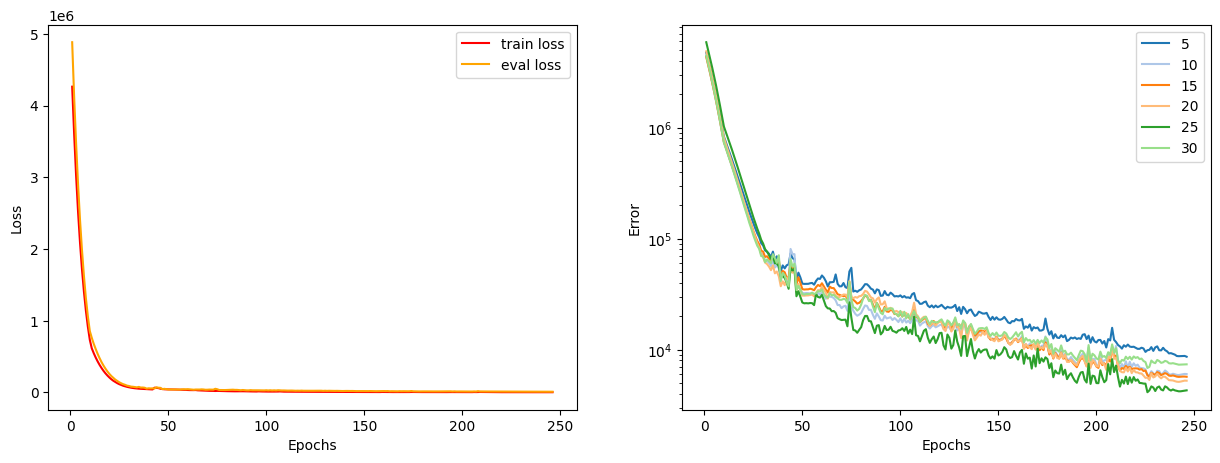

In [ ]:
# learning_rates = [0.1, 0.05]
learning_rates = [0.05]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    date_time_ = str(date_time).replace("/", "_")
    mamba_config = {'d_model': 8, 'n_layer': 1, 'd_state': 32, 'expand': 2, 'd_conv': 4, 'model_random_state': 42}
    model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
    training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam',
                       'optimizer_parameter': {'lr': lr}, \
                       'criterion': nn.MSELoss(), 'n_epochs': 400, 'early_stopping': 20, 'evaluation_time': 3,
                       'delta': 0.04, \
                       'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30], \
                       'verbose': True, 'device': device, 'continued': False, 'run': 1}
    training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
    # for bs in batch_sizes:
    #   for l in layers:
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'],
                     mamba_config['d_conv'])
    mamba_model = Mamba(args)

    all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
    all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

    training_mamba = Training(mamba_model, training_config)
    training_mamba.train(all_train_batches, all_val_batches)  #end of training loads the best model

    # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
    #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
    #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
    #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
    exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]),
                                       int(training_mamba.best_results[10]), int(training_mamba.best_results[20]), \
                                       lr, training_config['batch_size'], mamba_config['n_layer'],
                                       mamba_config['d_state'], \
                                       training_config['model_path'], test_filenames, mamba_config.copy(),
                                       training_config.copy(), \
                                       training_mamba.train_loss_history, training_mamba.eval_loss_history,
                                       training_mamba.eval_history, training_mamba.best_results]
    plot_training_summary(training_mamba)
    # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
    #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"05/11/2024, 08:16:04",9860,5827,5584,0.05,32,1,32,./Models/mamba_model_uav_dm8nl1ds32dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 1, 'd_state': 32, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4262764.197916667, 3606588.0520833335, 302403...","[4882583.544117647, 4124561.8088235296, 347154...","{5: [tensor(4748947.5000), tensor(4012754.), t...","{5: tensor(9860.8467), 10: tensor(5827.6797), ..."


In [18]:
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder'] + date_time_

with open(results_path, 'wb') as f:
    pickle.dump(exp_record, f)

OSError: [Errno 22] Invalid argument: './Mamba Training Results/mamba_training_results_split0.2_uav08_19_2025, 13:59:40'

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/11/2024, 04:57:09",3040,1931,3640,0.01,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{5: tensor(3040.7278), 10: tensor(1931.6913), ..."


In [ ]:
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder'] + date_time_

with open(results_path, 'wb') as f:
    pickle.dump(exp_record, f)

100%|██████████| 17/17 [00:00<00:00, 17.60it/s]


epoch 0: train loss = 4814974.322916667, eval loss = 4517158.426470588


100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


epoch 1: train loss = 4483031.84375, eval loss = 4206336.134191177


100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 2: train loss = 4158378.1354166665, eval loss = 3909674.21875


100%|██████████| 17/17 [00:00<00:00, 17.73it/s]


epoch 3: train loss = 3848065.5416666665, eval loss = 3633319.8786764704


100%|██████████| 17/17 [00:00<00:00, 18.15it/s]


epoch 4: train loss = 3554292.875, eval loss = 3363712.6709558824


100%|██████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 5: train loss = 3373674.3385416665, eval loss = 3313631.0588235296


100%|██████████| 17/17 [00:00<00:00, 17.72it/s]


epoch 6: train loss = 3316454.984375, eval loss = 3262328.1875


100%|██████████| 17/17 [00:00<00:00, 17.46it/s]


epoch 7: train loss = 3260324.2083333335, eval loss = 3212629.4172794116


100%|██████████| 17/17 [00:00<00:00, 19.63it/s]


epoch 8: train loss = 3203963.265625, eval loss = 3162253.507352941


100%|██████████| 17/17 [00:01<00:00, 16.13it/s]


epoch 9: train loss = 3147646.9322916665, eval loss = 3110808.3529411764


100%|██████████| 17/17 [00:01<00:00, 12.66it/s]


epoch 10: train loss = 3092166.1197916665, eval loss = 3061375.2150735296


100%|██████████| 17/17 [00:01<00:00, 12.81it/s]


epoch 11: train loss = 3037875.6458333335, eval loss = 3011357.193014706


100%|██████████| 17/17 [00:01<00:00, 13.18it/s]


epoch 12: train loss = 2984801.5260416665, eval loss = 2961412.7224264704


100%|██████████| 17/17 [00:01<00:00, 15.26it/s]


epoch 13: train loss = 2932116.359375, eval loss = 2911627.119485294


100%|██████████| 17/17 [00:00<00:00, 19.04it/s]


epoch 14: train loss = 2880527.9479166665, eval loss = 2863181.6599264704


100%|██████████| 17/17 [00:00<00:00, 18.43it/s]


epoch 15: train loss = 2829558.53125, eval loss = 2813899.555147059


100%|██████████| 17/17 [00:00<00:00, 19.67it/s]


epoch 16: train loss = 2779689.5520833335, eval loss = 2766236.786764706


100%|██████████| 17/17 [00:00<00:00, 19.34it/s]


epoch 17: train loss = 2730222.953125, eval loss = 2719174.998161765


100%|██████████| 17/17 [00:01<00:00, 15.49it/s]


epoch 18: train loss = 2681539.78125, eval loss = 2672223.913602941


100%|██████████| 17/17 [00:00<00:00, 19.00it/s]


epoch 19: train loss = 2633577.3177083335, eval loss = 2625903.1911764704


100%|██████████| 17/17 [00:00<00:00, 17.82it/s]


epoch 20: train loss = 2586298.046875, eval loss = 2580040.4485294116


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


epoch 21: train loss = 2539668.578125, eval loss = 2534707.6783088236


100%|██████████| 17/17 [00:00<00:00, 17.82it/s]


epoch 22: train loss = 2493665.578125, eval loss = 2489982.8860294116


100%|██████████| 17/17 [00:01<00:00, 16.84it/s]


epoch 23: train loss = 2448304.1927083335, eval loss = 2445875.0900735296


100%|██████████| 17/17 [00:01<00:00, 11.79it/s]


epoch 24: train loss = 2403598.9635416665, eval loss = 2402358.033088235


100%|██████████| 17/17 [00:01<00:00, 12.66it/s]


epoch 25: train loss = 2359558.71875, eval loss = 2359503.900735294


100%|██████████| 17/17 [00:01<00:00, 14.80it/s]


epoch 26: train loss = 2316168.015625, eval loss = 2317283.970588235


100%|██████████| 17/17 [00:00<00:00, 19.86it/s]


epoch 27: train loss = 2273403.9635416665, eval loss = 2275667.961397059


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 28: train loss = 2231247.4739583335, eval loss = 2234645.213235294


100%|██████████| 17/17 [00:00<00:00, 19.80it/s]


epoch 29: train loss = 2189688.09375, eval loss = 2194213.0845588236


100%|██████████| 17/17 [00:01<00:00, 16.45it/s]


epoch 30: train loss = 2148711.15625, eval loss = 2154261.7334558824


100%|██████████| 17/17 [00:00<00:00, 19.95it/s]


epoch 31: train loss = 2108309.2760416665, eval loss = 2114940.117647059


100%|██████████| 17/17 [00:00<00:00, 19.34it/s]


epoch 32: train loss = 2068475.1354166667, eval loss = 2076091.5386029412


100%|██████████| 17/17 [00:00<00:00, 17.79it/s]


epoch 33: train loss = 2029202.0572916667, eval loss = 2037760.346507353


100%|██████████| 17/17 [00:00<00:00, 18.05it/s]


epoch 34: train loss = 1990485.8177083333, eval loss = 1999829.356617647


100%|██████████| 17/17 [00:00<00:00, 17.87it/s]


epoch 35: train loss = 1952319.3125, eval loss = 1962416.1636029412


100%|██████████| 17/17 [00:01<00:00, 12.94it/s]


epoch 36: train loss = 1914694.25, eval loss = 1925376.4016544118


100%|██████████| 17/17 [00:01<00:00, 12.03it/s]


epoch 37: train loss = 1877605.5963541667, eval loss = 1888864.3207720588


100%|██████████| 17/17 [00:01<00:00, 11.51it/s]


epoch 38: train loss = 1841049.8463541667, eval loss = 1852743.6461397058


100%|██████████| 17/17 [00:00<00:00, 17.25it/s]


epoch 39: train loss = 1805013.546875, eval loss = 1816840.3538602942


100%|██████████| 17/17 [00:00<00:00, 19.48it/s]


epoch 40: train loss = 1769495.890625, eval loss = 1781070.75


100%|██████████| 17/17 [00:00<00:00, 19.11it/s]


epoch 41: train loss = 1734486.4791666667, eval loss = 1746332.4834558824


100%|██████████| 17/17 [00:00<00:00, 17.91it/s]


epoch 42: train loss = 1700002.9739583333, eval loss = 1712101.934742647


100%|██████████| 17/17 [00:00<00:00, 19.20it/s]


epoch 43: train loss = 1665989.1067708333, eval loss = 1679170.1626838236


100%|██████████| 17/17 [00:00<00:00, 20.31it/s]


epoch 44: train loss = 1632517.4322916667, eval loss = 1645847.5955882352


100%|██████████| 17/17 [00:00<00:00, 19.78it/s]


epoch 45: train loss = 1599492.40625, eval loss = 1613861.3511029412


100%|██████████| 17/17 [00:00<00:00, 17.46it/s]


epoch 46: train loss = 1566992.8619791667, eval loss = 1581591.809742647


100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


epoch 47: train loss = 1534964.5911458333, eval loss = 1549880.6553308824


100%|██████████| 17/17 [00:01<00:00, 12.44it/s]


epoch 48: train loss = 1503423.9036458333, eval loss = 1518615.6424632352


100%|██████████| 17/17 [00:01<00:00, 10.60it/s]


epoch 49: train loss = 1472359.8151041667, eval loss = 1487619.6176470588


100%|██████████| 17/17 [00:01<00:00, 12.93it/s]


epoch 50: train loss = 1441769.1510416667, eval loss = 1457607.8648897058


100%|██████████| 17/17 [00:01<00:00, 15.92it/s]


epoch 51: train loss = 1411656.2057291667, eval loss = 1427962.981617647


100%|██████████| 17/17 [00:01<00:00, 15.98it/s]


epoch 52: train loss = 1382003.3958333333, eval loss = 1398883.7729779412


100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 53: train loss = 1352821.4635416667, eval loss = 1370119.799632353


100%|██████████| 17/17 [00:00<00:00, 19.03it/s]


epoch 54: train loss = 1324102.2708333333, eval loss = 1341856.3511029412


100%|██████████| 17/17 [00:00<00:00, 19.14it/s]


epoch 55: train loss = 1295842.4479166667, eval loss = 1314179.190257353


100%|██████████| 17/17 [00:00<00:00, 19.38it/s]


epoch 56: train loss = 1268035.4739583333, eval loss = 1286802.4200367648


100%|██████████| 17/17 [00:00<00:00, 17.59it/s]


epoch 57: train loss = 1240675.6875, eval loss = 1259343.2288602942


100%|██████████| 17/17 [00:00<00:00, 19.26it/s]


epoch 58: train loss = 1213757.4817708333, eval loss = 1232472.2564338236


100%|██████████| 17/17 [00:01<00:00, 15.31it/s]


epoch 59: train loss = 1187277.8932291667, eval loss = 1206628.3988970588


100%|██████████| 17/17 [00:00<00:00, 18.42it/s]


epoch 60: train loss = 1161229.9817708333, eval loss = 1180937.953125


100%|██████████| 17/17 [00:00<00:00, 17.92it/s]


epoch 61: train loss = 1135613.4765625, eval loss = 1155548.6957720588


100%|██████████| 17/17 [00:01<00:00, 12.62it/s]


epoch 62: train loss = 1110420.3098958333, eval loss = 1130420.9788602942


100%|██████████| 17/17 [00:01<00:00, 12.06it/s]


epoch 63: train loss = 1085647.5911458333, eval loss = 1105831.5992647058


100%|██████████| 17/17 [00:01<00:00, 13.60it/s]


epoch 64: train loss = 1061291.9505208333, eval loss = 1081828.0863970588


100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


epoch 65: train loss = 1037350.2604166666, eval loss = 1058317.090992647


100%|██████████| 17/17 [00:00<00:00, 19.62it/s]


epoch 66: train loss = 1013816.4869791666, eval loss = 1035199.9080882353


100%|██████████| 17/17 [00:00<00:00, 17.93it/s]


epoch 67: train loss = 990686.640625, eval loss = 1012472.1939338235


100%|██████████| 17/17 [00:00<00:00, 19.22it/s]


epoch 68: train loss = 967956.1979166666, eval loss = 990167.7803308824


100%|██████████| 17/17 [00:00<00:00, 17.57it/s]


epoch 69: train loss = 945622.2734375, eval loss = 968232.9352022059


100%|██████████| 17/17 [00:00<00:00, 19.99it/s]


epoch 70: train loss = 923679.2278645834, eval loss = 946656.546875


100%|██████████| 17/17 [00:00<00:00, 19.92it/s]


epoch 71: train loss = 902124.6080729166, eval loss = 925519.5983455882


100%|██████████| 17/17 [00:01<00:00, 16.57it/s]


epoch 72: train loss = 880951.30078125, eval loss = 904760.3782169118


100%|██████████| 17/17 [00:01<00:00, 13.73it/s]


epoch 73: train loss = 860157.2200520834, eval loss = 884357.3786764706


100%|██████████| 17/17 [00:01<00:00, 13.21it/s]


epoch 74: train loss = 839737.74609375, eval loss = 864296.1208639706


100%|██████████| 17/17 [00:01<00:00, 12.99it/s]


epoch 75: train loss = 819688.37890625, eval loss = 844570.9659926471


100%|██████████| 17/17 [00:01<00:00, 16.98it/s]


epoch 76: train loss = 800004.9674479166, eval loss = 825171.7045036765


100%|██████████| 17/17 [00:00<00:00, 18.54it/s]


epoch 77: train loss = 780683.1158854166, eval loss = 806084.8998161765


100%|██████████| 17/17 [00:01<00:00, 16.15it/s]


epoch 78: train loss = 761719.359375, eval loss = 787288.3575367647


100%|██████████| 17/17 [00:01<00:00, 15.03it/s]


epoch 79: train loss = 743109.5729166666, eval loss = 768828.0395220588


100%|██████████| 17/17 [00:00<00:00, 17.71it/s]


epoch 80: train loss = 724848.203125, eval loss = 750720.9131433824


100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 81: train loss = 706931.61328125, eval loss = 732958.3432904412


100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 82: train loss = 689355.6614583334, eval loss = 715529.3616727941


100%|██████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 83: train loss = 672116.01953125, eval loss = 698420.8368566176


100%|██████████| 17/17 [00:00<00:00, 18.89it/s]


epoch 84: train loss = 655208.7161458334, eval loss = 681622.8005514706


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


epoch 85: train loss = 638629.6223958334, eval loss = 665122.4241727941


100%|██████████| 17/17 [00:01<00:00, 14.00it/s]


epoch 86: train loss = 622374.0455729166, eval loss = 648912.1245404412


100%|██████████| 17/17 [00:01<00:00, 12.36it/s]


epoch 87: train loss = 606438.2578125, eval loss = 633002.1580882353


100%|██████████| 17/17 [00:01<00:00, 11.55it/s]


epoch 88: train loss = 590818.5546875, eval loss = 617399.4260110294


100%|██████████| 17/17 [00:00<00:00, 17.66it/s]


epoch 89: train loss = 575511.37890625, eval loss = 602092.3699448529


100%|██████████| 17/17 [00:00<00:00, 18.77it/s]


epoch 90: train loss = 560512.0755208334, eval loss = 587077.765625


100%|██████████| 17/17 [00:00<00:00, 19.16it/s]


epoch 91: train loss = 545817.45703125, eval loss = 572351.9839154412


100%|██████████| 17/17 [00:00<00:00, 19.08it/s]


epoch 92: train loss = 531423.1705729166, eval loss = 557913.6645220588


100%|██████████| 17/17 [00:01<00:00, 16.70it/s]


epoch 93: train loss = 517325.9361979167, eval loss = 543761.9802389706


100%|██████████| 17/17 [00:00<00:00, 19.76it/s]


epoch 94: train loss = 503521.2747395833, eval loss = 529894.1056985294


100%|██████████| 17/17 [00:00<00:00, 19.79it/s]


epoch 95: train loss = 490005.7981770833, eval loss = 516312.6323529412


100%|██████████| 17/17 [00:00<00:00, 19.70it/s]


epoch 96: train loss = 476775.9466145833, eval loss = 503019.5960477941


100%|██████████| 17/17 [00:00<00:00, 18.18it/s]


epoch 97: train loss = 463827.9440104167, eval loss = 490018.09375


100%|██████████| 17/17 [00:01<00:00, 13.15it/s]


epoch 98: train loss = 451158.4986979167, eval loss = 477306.1369485294


100%|██████████| 17/17 [00:01<00:00, 11.75it/s]


epoch 99: train loss = 438763.3958333333, eval loss = 464878.6603860294


100%|██████████| 17/17 [00:01<00:00, 13.56it/s]


epoch 100: train loss = 426639.0299479167, eval loss = 452734.4142922794


100%|██████████| 17/17 [00:00<00:00, 18.58it/s]


epoch 101: train loss = 414782.865234375, eval loss = 440866.6171875


100%|██████████| 17/17 [00:00<00:00, 17.53it/s]


epoch 102: train loss = 403190.8430989583, eval loss = 429264.87362132355


100%|██████████| 17/17 [00:00<00:00, 17.04it/s]


epoch 103: train loss = 391858.9329427083, eval loss = 417924.9604779412


100%|██████████| 17/17 [00:00<00:00, 19.79it/s]


epoch 104: train loss = 380784.0852864583, eval loss = 406833.5073529412


100%|██████████| 17/17 [00:00<00:00, 19.74it/s]


epoch 105: train loss = 369962.5006510417, eval loss = 395989.11006433825


100%|██████████| 17/17 [00:00<00:00, 17.17it/s]


epoch 106: train loss = 359390.673828125, eval loss = 385389.9469209559


100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


epoch 107: train loss = 349065.5384114583, eval loss = 375027.75390625


100%|██████████| 17/17 [00:00<00:00, 18.44it/s]


epoch 108: train loss = 338983.3509114583, eval loss = 364905.29021139705


100%|██████████| 17/17 [00:00<00:00, 17.60it/s]


epoch 109: train loss = 329140.7428385417, eval loss = 355026.9510569853


100%|██████████| 17/17 [00:00<00:00, 19.11it/s]


epoch 110: train loss = 319534.34765625, eval loss = 345393.8226102941


100%|██████████| 17/17 [00:01<00:00, 12.13it/s]


epoch 111: train loss = 310160.306640625, eval loss = 336003.6969209559


100%|██████████| 17/17 [00:01<00:00, 13.26it/s]


epoch 112: train loss = 301015.4388020833, eval loss = 326826.4685202206


100%|██████████| 17/17 [00:01<00:00, 12.34it/s]


epoch 113: train loss = 292096.1907552083, eval loss = 317785.8127297794


100%|██████████| 17/17 [00:01<00:00, 15.85it/s]


epoch 114: train loss = 283398.2916666667, eval loss = 308864.8478860294


100%|██████████| 17/17 [00:00<00:00, 17.70it/s]


epoch 115: train loss = 274919.6770833333, eval loss = 300092.9453125


100%|██████████| 17/17 [00:00<00:00, 18.70it/s]


epoch 116: train loss = 266661.3209635417, eval loss = 291486.97012867645


100%|██████████| 17/17 [00:00<00:00, 18.95it/s]


epoch 117: train loss = 258627.30989583334, eval loss = 283181.4781709559


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


epoch 118: train loss = 250816.31119791666, eval loss = 275153.01424632355


100%|██████████| 17/17 [00:00<00:00, 18.90it/s]


epoch 119: train loss = 243219.16861979166, eval loss = 267323.95703125


100%|██████████| 17/17 [00:00<00:00, 19.35it/s]


epoch 120: train loss = 235825.94791666666, eval loss = 259734.9473805147


100%|██████████| 17/17 [00:00<00:00, 17.84it/s]


epoch 121: train loss = 228649.01888020834, eval loss = 252354.39613970587


100%|██████████| 17/17 [00:00<00:00, 17.81it/s]


epoch 122: train loss = 221683.22395833334, eval loss = 245243.33065257352


100%|██████████| 17/17 [00:01<00:00, 16.71it/s]


epoch 123: train loss = 214928.30501302084, eval loss = 238285.82973345587


100%|██████████| 17/17 [00:01<00:00, 14.24it/s]


epoch 124: train loss = 208406.64680989584, eval loss = 231832.00068933822


100%|██████████| 17/17 [00:01<00:00, 11.08it/s]


epoch 125: train loss = 202123.57779947916, eval loss = 224083.19416360295


100%|██████████| 17/17 [00:01<00:00, 13.30it/s]


epoch 126: train loss = 195845.607421875, eval loss = 218004.31330422795


100%|██████████| 17/17 [00:01<00:00, 16.34it/s]


epoch 127: train loss = 189527.08561197916, eval loss = 212517.62959558822


100%|██████████| 17/17 [00:00<00:00, 19.21it/s]


epoch 128: train loss = 183393.85872395834, eval loss = 205545.7342601103


100%|██████████| 17/17 [00:01<00:00, 16.70it/s]


epoch 129: train loss = 177561.48795572916, eval loss = 199657.72518382352


100%|██████████| 17/17 [00:00<00:00, 18.26it/s]


epoch 130: train loss = 171966.77962239584, eval loss = 194061.43244485295


100%|██████████| 17/17 [00:00<00:00, 19.53it/s]


epoch 131: train loss = 166572.00944010416, eval loss = 188554.04009650735


100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 132: train loss = 161340.1611328125, eval loss = 182952.81962316178


100%|██████████| 17/17 [00:01<00:00, 16.60it/s]


epoch 133: train loss = 156275.85611979166, eval loss = 177871.70611213235


100%|██████████| 17/17 [00:00<00:00, 18.40it/s]


epoch 134: train loss = 151363.55143229166, eval loss = 172221.0920266544


100%|██████████| 17/17 [00:00<00:00, 17.02it/s]


epoch 135: train loss = 146604.1689453125, eval loss = 167276.10386029413


100%|██████████| 17/17 [00:00<00:00, 19.40it/s]


epoch 136: train loss = 141987.68424479166, eval loss = 162718.92474724265


100%|██████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 137: train loss = 137522.30501302084, eval loss = 158200.3083639706


100%|██████████| 17/17 [00:01<00:00, 11.43it/s]


epoch 138: train loss = 133195.0625, eval loss = 153653.78825827205


100%|██████████| 17/17 [00:01<00:00, 10.52it/s]


epoch 139: train loss = 129009.94889322917, eval loss = 149474.88051470587


100%|██████████| 17/17 [00:01<00:00, 12.45it/s]


epoch 140: train loss = 124968.8291015625, eval loss = 144780.09076286765


100%|██████████| 17/17 [00:01<00:00, 13.16it/s]


epoch 141: train loss = 121069.17252604167, eval loss = 140704.99678308822


100%|██████████| 17/17 [00:00<00:00, 18.43it/s]


epoch 142: train loss = 117275.5927734375, eval loss = 136940.12189797795


100%|██████████| 17/17 [00:00<00:00, 18.71it/s]


epoch 143: train loss = 113616.4609375, eval loss = 133205.39935661765


100%|██████████| 17/17 [00:00<00:00, 18.14it/s]


epoch 144: train loss = 110091.83040364583, eval loss = 129499.353515625


100%|██████████| 17/17 [00:00<00:00, 17.59it/s]


epoch 145: train loss = 106694.30419921875, eval loss = 125885.71909466911


100%|██████████| 17/17 [00:00<00:00, 18.63it/s]


epoch 146: train loss = 103411.26953125, eval loss = 122389.81881893383


100%|██████████| 17/17 [00:00<00:00, 18.23it/s]


epoch 147: train loss = 100253.33349609375, eval loss = 119047.54733455883


100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 148: train loss = 97205.64680989583, eval loss = 115841.66555606617


100%|██████████| 17/17 [00:00<00:00, 19.12it/s]


epoch 149: train loss = 94274.0283203125, eval loss = 112746.2403492647


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 150: train loss = 91443.552734375, eval loss = 109736.94784007352


100%|██████████| 17/17 [00:01<00:00, 14.03it/s]


epoch 151: train loss = 88717.38102213542, eval loss = 106761.71271829044


100%|██████████| 17/17 [00:01<00:00, 11.35it/s]


epoch 152: train loss = 86089.60904947917, eval loss = 103882.55106847426


100%|██████████| 17/17 [00:01<00:00, 12.38it/s]


epoch 153: train loss = 83566.36051432292, eval loss = 101095.89056755515


100%|██████████| 17/17 [00:01<00:00, 16.62it/s]


epoch 154: train loss = 81147.57503255208, eval loss = 98515.99758731617


100%|██████████| 17/17 [00:00<00:00, 18.47it/s]


epoch 155: train loss = 78827.3740234375, eval loss = 96040.55238970589


100%|██████████| 17/17 [00:01<00:00, 16.83it/s]


epoch 156: train loss = 76598.92952473958, eval loss = 93707.74431295956


100%|██████████| 17/17 [00:01<00:00, 15.98it/s]


epoch 157: train loss = 74453.14664713542, eval loss = 91256.2177734375


100%|██████████| 17/17 [00:00<00:00, 19.23it/s]


epoch 158: train loss = 72361.47086588542, eval loss = 88642.69514016544


100%|██████████| 17/17 [00:00<00:00, 18.89it/s]


epoch 159: train loss = 70344.75748697917, eval loss = 85931.0584788603


100%|██████████| 17/17 [00:01<00:00, 16.87it/s]


epoch 160: train loss = 68483.80973307292, eval loss = 83621.86161534926


100%|██████████| 17/17 [00:01<00:00, 16.30it/s]


epoch 161: train loss = 66754.33138020833, eval loss = 81813.43744255515


100%|██████████| 17/17 [00:01<00:00, 16.96it/s]


epoch 162: train loss = 65068.192708333336, eval loss = 80508.89504825367


100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 163: train loss = 63416.548990885414, eval loss = 79227.306640625


100%|██████████| 17/17 [00:00<00:00, 19.02it/s]


epoch 164: train loss = 61923.376139322914, eval loss = 77489.47116268383


100%|██████████| 17/17 [00:01<00:00, 12.49it/s]


epoch 165: train loss = 60294.0908203125, eval loss = 73752.26361443015


100%|██████████| 17/17 [00:01<00:00, 11.65it/s]


epoch 166: train loss = 58834.10546875, eval loss = 71485.4871897978


100%|██████████| 17/17 [00:01<00:00, 14.00it/s]


epoch 167: train loss = 57608.87060546875, eval loss = 72596.32255284926


100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 168: train loss = 56200.059733072914, eval loss = 69570.92928538602


100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 169: train loss = 54675.43115234375, eval loss = 67227.1026539522


100%|██████████| 17/17 [00:00<00:00, 19.60it/s]


epoch 170: train loss = 53612.594563802086, eval loss = 67491.39780560661


100%|██████████| 17/17 [00:00<00:00, 19.05it/s]


epoch 171: train loss = 52420.873046875, eval loss = 65847.5526194853


100%|██████████| 17/17 [00:00<00:00, 19.65it/s]


epoch 172: train loss = 51135.627115885414, eval loss = 63568.61092601103


100%|██████████| 17/17 [00:00<00:00, 18.87it/s]


epoch 173: train loss = 50110.18855794271, eval loss = 62425.42216222426


100%|██████████| 17/17 [00:00<00:00, 19.12it/s]


epoch 174: train loss = 49784.695963541664, eval loss = 62616.00201056985


100%|██████████| 17/17 [00:00<00:00, 19.56it/s]


epoch 175: train loss = 50779.8701171875, eval loss = 62506.002125459556


100%|██████████| 17/17 [00:00<00:00, 19.27it/s]


epoch 176: train loss = 48868.176025390625, eval loss = 58320.04141773897


100%|██████████| 17/17 [00:00<00:00, 18.34it/s]


epoch 177: train loss = 47134.66267903646, eval loss = 56581.48813763787


100%|██████████| 17/17 [00:01<00:00, 11.24it/s]


epoch 178: train loss = 46106.23380533854, eval loss = 55028.694221047794


100%|██████████| 17/17 [00:01<00:00, 10.89it/s]


epoch 179: train loss = 45180.759928385414, eval loss = 54115.998908547794


100%|██████████| 17/17 [00:01<00:00, 11.45it/s]


epoch 180: train loss = 44370.95320638021, eval loss = 53203.013011259194


100%|██████████| 17/17 [00:01<00:00, 16.81it/s]


epoch 181: train loss = 43606.360595703125, eval loss = 52279.81812959559


100%|██████████| 17/17 [00:01<00:00, 16.03it/s]


epoch 182: train loss = 42892.21931966146, eval loss = 51639.593864889706


100%|██████████| 17/17 [00:01<00:00, 15.08it/s]


epoch 183: train loss = 42225.975260416664, eval loss = 50981.692411534925


100%|██████████| 17/17 [00:00<00:00, 17.43it/s]


epoch 184: train loss = 41596.97371419271, eval loss = 50348.71171300551


100%|██████████| 17/17 [00:00<00:00, 18.57it/s]


epoch 185: train loss = 41009.356282552086, eval loss = 49709.93129595588


100%|██████████| 17/17 [00:01<00:00, 16.62it/s]


epoch 186: train loss = 40451.84952799479, eval loss = 49095.76180491728


100%|██████████| 17/17 [00:00<00:00, 19.98it/s]


epoch 187: train loss = 39921.74617513021, eval loss = 48550.65716911765


100%|██████████| 17/17 [00:01<00:00, 16.20it/s]


epoch 188: train loss = 39417.95157877604, eval loss = 48044.13749425551


100%|██████████| 17/17 [00:00<00:00, 19.71it/s]


epoch 189: train loss = 38944.143880208336, eval loss = 47355.543083639706


100%|██████████| 17/17 [00:01<00:00, 16.71it/s]


epoch 190: train loss = 38495.81339518229, eval loss = 46893.108025045956


100%|██████████| 17/17 [00:00<00:00, 17.79it/s]


epoch 191: train loss = 38068.48575846354, eval loss = 46482.56160960478


100%|██████████| 17/17 [00:01<00:00, 11.11it/s]


epoch 192: train loss = 37656.77693684896, eval loss = 46151.841136259194


100%|██████████| 17/17 [00:01<00:00, 10.52it/s]


epoch 193: train loss = 37256.064778645836, eval loss = 45905.41024241728


100%|██████████| 17/17 [00:01<00:00, 13.16it/s]


epoch 194: train loss = 36858.244791666664, eval loss = 45726.95631318934


100%|██████████| 17/17 [00:01<00:00, 12.78it/s]


epoch 195: train loss = 36461.62312825521, eval loss = 45584.53883272059


100%|██████████| 17/17 [00:01<00:00, 12.67it/s]


epoch 196: train loss = 36069.923502604164, eval loss = 45435.542107077206


100%|██████████| 17/17 [00:00<00:00, 18.31it/s]


epoch 197: train loss = 35681.432942708336, eval loss = 45244.71875


100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


epoch 198: train loss = 35294.830729166664, eval loss = 45004.58616727941


100%|██████████| 17/17 [00:00<00:00, 19.07it/s]


epoch 199: train loss = 34915.32283528646, eval loss = 44756.6176183364


100%|██████████| 17/17 [00:00<00:00, 17.89it/s]


epoch 200: train loss = 34545.473876953125, eval loss = 44569.57416130515


100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 201: train loss = 34176.163736979164, eval loss = 44440.22041590074


100%|██████████| 17/17 [00:00<00:00, 17.41it/s]


epoch 202: train loss = 33794.339599609375, eval loss = 44315.04638671875


100%|██████████| 17/17 [00:00<00:00, 18.52it/s]


epoch 203: train loss = 33399.423828125, eval loss = 44197.53759765625


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


epoch 204: train loss = 32989.439208984375, eval loss = 44072.61405675551


100%|██████████| 17/17 [00:00<00:00, 18.65it/s]


epoch 205: train loss = 32518.904947916668, eval loss = 43940.789579503675


100%|██████████| 17/17 [00:01<00:00, 12.84it/s]


epoch 206: train loss = 31867.843668619793, eval loss = 43535.653923483456


100%|██████████| 17/17 [00:01<00:00, 10.76it/s]


epoch 207: train loss = 31666.69384765625, eval loss = 41865.78745404412


100%|██████████| 17/17 [00:01<00:00, 12.62it/s]


epoch 208: train loss = 32211.886149088543, eval loss = 48202.162913602944


100%|██████████| 17/17 [00:01<00:00, 12.75it/s]


epoch 209: train loss = 30463.82861328125, eval loss = 42022.195140165444


100%|██████████| 17/17 [00:00<00:00, 18.69it/s]


epoch 210: train loss = 29850.131754557293, eval loss = 42552.699879365806


100%|██████████| 17/17 [00:00<00:00, 19.59it/s]


epoch 211: train loss = 29436.550618489582, eval loss = 42966.346162683825


100%|██████████| 17/17 [00:00<00:00, 17.64it/s]


epoch 212: train loss = 27907.565511067707, eval loss = 43302.339183134194


100%|██████████| 17/17 [00:01<00:00, 16.61it/s]


epoch 213: train loss = 27125.6533203125, eval loss = 43584.84791475184


100%|██████████| 17/17 [00:01<00:00, 15.71it/s]


epoch 214: train loss = 26323.67997233073, eval loss = 40947.01743451287


100%|██████████| 17/17 [00:00<00:00, 17.63it/s]


epoch 215: train loss = 25892.49540201823, eval loss = 40936.576775045956


100%|██████████| 17/17 [00:01<00:00, 16.68it/s]


epoch 216: train loss = 25230.996663411457, eval loss = 43127.76576861213


100%|██████████| 17/17 [00:00<00:00, 18.36it/s]


epoch 217: train loss = 24343.862955729168, eval loss = 42886.57846966912


100%|██████████| 17/17 [00:01<00:00, 15.03it/s]


epoch 218: train loss = 23575.553385416668, eval loss = 42876.379911534925


100%|██████████| 17/17 [00:00<00:00, 17.29it/s]


epoch 219: train loss = 23077.477172851562, eval loss = 42893.79667394301


100%|██████████| 17/17 [00:01<00:00, 13.40it/s]


epoch 220: train loss = 22412.758626302082, eval loss = 42620.58988683364


100%|██████████| 17/17 [00:01<00:00, 11.58it/s]


epoch 221: train loss = 21964.427978515625, eval loss = 42643.27435661765


100%|██████████| 17/17 [00:01<00:00, 13.22it/s]


epoch 222: train loss = 21492.252970377605, eval loss = 42698.295654296875


100%|██████████| 17/17 [00:00<00:00, 17.06it/s]


epoch 223: train loss = 21064.89969889323, eval loss = 42743.9538861443


100%|██████████| 17/17 [00:00<00:00, 18.81it/s]


epoch 224: train loss = 20673.376098632812, eval loss = 42811.86481789982


100%|██████████| 17/17 [00:00<00:00, 19.96it/s]


epoch 225: train loss = 20288.189127604168, eval loss = 42671.54400275735


100%|██████████| 17/17 [00:00<00:00, 18.57it/s]


epoch 226: train loss = 19886.776774088543, eval loss = 42571.50963637408


100%|██████████| 17/17 [00:00<00:00, 19.02it/s]


epoch 227: train loss = 19530.322347005207, eval loss = 42483.68709788603


100%|██████████| 17/17 [00:00<00:00, 19.27it/s]


epoch 228: train loss = 19202.080078125, eval loss = 42419.581298828125


100%|██████████| 17/17 [00:00<00:00, 19.31it/s]


epoch 229: train loss = 18889.005249023438, eval loss = 42425.247242647056


100%|██████████| 17/17 [00:00<00:00, 17.05it/s]


epoch 230: train loss = 18589.798461914062, eval loss = 42359.43191348805


100%|██████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 231: train loss = 18303.071614583332, eval loss = 42483.227998621325


100%|██████████| 17/17 [00:00<00:00, 18.66it/s]


epoch 232: train loss = 18087.691243489582, eval loss = 42411.945685891544


100%|██████████| 17/17 [00:01<00:00, 12.73it/s]


epoch 233: train loss = 17863.24979654948, eval loss = 42435.771369485294


100%|██████████| 17/17 [00:01<00:00, 12.75it/s]


epoch 234: train loss = 17580.831949869793, eval loss = 42495.38512465533


100%|██████████| 17/17 [00:01<00:00, 12.81it/s]


epoch 235: train loss = 17290.832438151043, eval loss = 42513.31953699449


100%|██████████| 17/17 [00:01<00:00, 13.85it/s]


epoch 236: train loss = 17070.677408854168, eval loss = 42607.554084329044


100%|██████████| 17/17 [00:00<00:00, 17.81it/s]


epoch 237: train loss = 16827.206624348957, eval loss = 42589.045309627756


100%|██████████| 17/17 [00:00<00:00, 18.34it/s]


epoch 238: train loss = 16558.124837239582, eval loss = 42687.261330997244


100%|██████████| 17/17 [00:00<00:00, 19.29it/s]


epoch 239: train loss = 16295.367513020834, eval loss = 42644.35213694853


100%|██████████| 17/17 [00:01<00:00, 16.52it/s]


epoch 240: train loss = 16053.761454264322, eval loss = 42562.06005859375


100%|██████████| 17/17 [00:00<00:00, 19.16it/s]


epoch 241: train loss = 15812.351542154947, eval loss = 42352.40661621094


100%|██████████| 17/17 [00:00<00:00, 19.74it/s]


epoch 242: train loss = 15582.95703125, eval loss = 42007.8468951057


100%|██████████| 17/17 [00:00<00:00, 18.58it/s]


epoch 243: train loss = 15368.388875325521, eval loss = 41524.39869600184


100%|██████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 244: train loss = 15170.910400390625, eval loss = 40985.234999712775


100%|██████████| 17/17 [00:00<00:00, 19.44it/s]


epoch 245: train loss = 14991.837381998697, eval loss = 40352.96673224954


100%|██████████| 17/17 [00:01<00:00, 13.82it/s]


epoch 246: train loss = 14836.414733886719, eval loss = 39710.688174977025


100%|██████████| 17/17 [00:01<00:00, 12.35it/s]


epoch 247: train loss = 14723.347717285156, eval loss = 38860.00747501149


100%|██████████| 17/17 [00:01<00:00, 12.73it/s]


epoch 248: train loss = 14650.980122884115, eval loss = 38031.52302102482


100%|██████████| 17/17 [00:00<00:00, 18.50it/s]


epoch 249: train loss = 14555.07607014974, eval loss = 38027.53846650965


100%|██████████| 17/17 [00:00<00:00, 19.41it/s]


epoch 250: train loss = 14467.425537109375, eval loss = 38686.37826717601


100%|██████████| 17/17 [00:00<00:00, 18.81it/s]


epoch 251: train loss = 14140.927062988281, eval loss = 39181.471076516544


100%|██████████| 17/17 [00:01<00:00, 16.91it/s]


epoch 252: train loss = 13890.464599609375, eval loss = 39117.89397834329


100%|██████████| 17/17 [00:00<00:00, 19.81it/s]


epoch 253: train loss = 13816.989664713541, eval loss = 38887.79982622932


100%|██████████| 17/17 [00:00<00:00, 17.84it/s]


epoch 254: train loss = 13673.013000488281, eval loss = 38535.38806152344


100%|██████████| 17/17 [00:00<00:00, 18.23it/s]


epoch 255: train loss = 13613.63525390625, eval loss = 38793.59586827895


100%|██████████| 17/17 [00:00<00:00, 18.69it/s]


epoch 256: train loss = 13456.984802246094, eval loss = 38996.029792336856


100%|██████████| 17/17 [00:01<00:00, 16.92it/s]


epoch 257: train loss = 13276.991760253906, eval loss = 39674.79314826516


100%|██████████| 17/17 [00:01<00:00, 12.48it/s]


epoch 258: train loss = 13077.887512207031, eval loss = 39797.4381534352


100%|██████████| 17/17 [00:01<00:00, 13.38it/s]


epoch 259: train loss = 13005.644714355469, eval loss = 40138.1745892693


100%|██████████| 17/17 [00:01<00:00, 15.67it/s]


epoch 260: train loss = 12828.498229980469, eval loss = 40340.29709759881


100%|██████████| 17/17 [00:00<00:00, 18.53it/s]


epoch 261: train loss = 12794.742350260416, eval loss = 40326.243336397056


100%|██████████| 17/17 [00:00<00:00, 18.74it/s]


epoch 262: train loss = 12603.207295735678, eval loss = 41000.1975887523


100%|██████████| 17/17 [00:00<00:00, 19.05it/s]


epoch 263: train loss = 12603.985148111979, eval loss = 40558.68390251609


100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


epoch 264: train loss = 12389.339497884115, eval loss = 41573.37038286994


100%|██████████| 17/17 [00:00<00:00, 19.81it/s]


epoch 265: train loss = 12396.727966308594, eval loss = 40971.58033662684


100%|██████████| 17/17 [00:00<00:00, 19.07it/s]


epoch 266: train loss = 12160.910034179688, eval loss = 41953.11943502987


100%|██████████| 17/17 [00:00<00:00, 19.17it/s]


epoch 267: train loss = 12202.738850911459, eval loss = 41397.637882008275


100%|██████████| 17/17 [00:00<00:00, 19.41it/s]


epoch 268: train loss = 11958.72226969401, eval loss = 41974.320427389706

Early stoping after 268 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 33698.71484375
Best train loss = 14650.980122884115
Best eval loss = 38031.52302102482
Best 5sec eval = 40271.09765625
Best 10sec eval = 33698.71484375
Best 15sec eval = 28732.75
Best 20sec eval = 48598.25
Best 25sec eval = 20468.92578125
Best 30sec eval = 25529.99609375


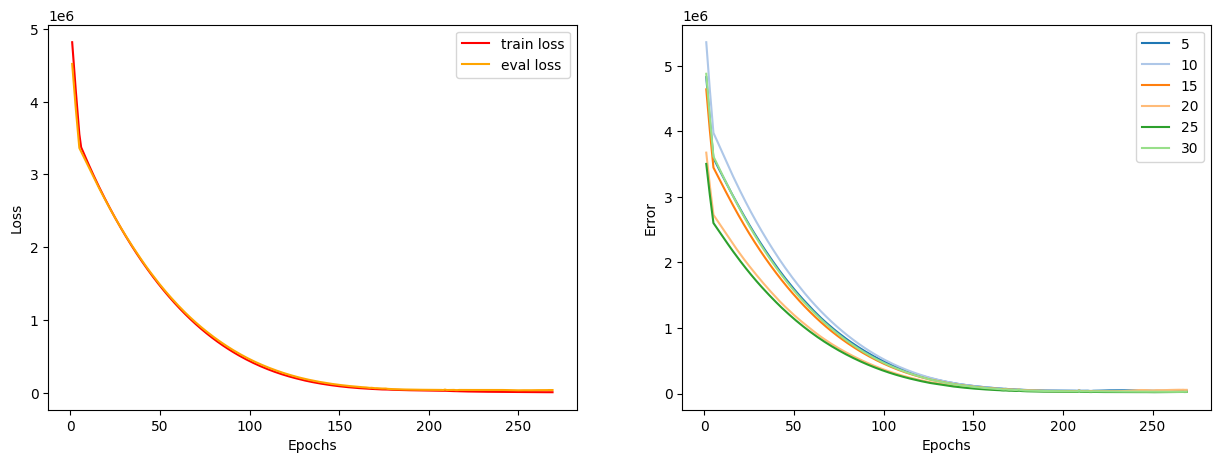

In [ ]:
# learning_rates = [0.1, 0.05]
learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    date_time_ = str(date_time).replace("/", "_")
    mamba_config = {'d_model': 8, 'n_layer': 1, 'd_state': 16, 'expand': 2, 'd_conv': 4, 'model_random_state': 42}
    model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
    training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam',
                       'optimizer_parameter': {'lr': lr}, \
                       'criterion': nn.MSELoss(), 'n_epochs': 600, 'early_stopping': 20, 'evaluation_time': 3,
                       'delta': 0.04, \
                       'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30], \
                       'verbose': True, 'device': device, 'continued': False, 'run': 1}
    training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
    # for bs in batch_sizes:
    #   for l in layers:
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'],
                     mamba_config['d_conv'])
    mamba_model = Mamba(args)

    all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
    all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

    training_mamba = Training(mamba_model, training_config)
    training_mamba.train(all_train_batches, all_val_batches)  #end of training loads the best model

    # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
    #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
    #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
    #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
    exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]),
                                       int(training_mamba.best_results[10]), int(training_mamba.best_results[20]), \
                                       lr, training_config['batch_size'], mamba_config['n_layer'],
                                       mamba_config['d_state'], \
                                       training_config['model_path'], test_filenames, mamba_config.copy(),
                                       training_config.copy(), \
                                       training_mamba.train_loss_history, training_mamba.eval_loss_history,
                                       training_mamba.eval_history, training_mamba.best_results]
    plot_training_summary(training_mamba)
    # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
    #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/04/2024, 11:45:41",40271,33698,48598,0.01,32,1,16,./Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4814974.322916667, 4483031.84375, 4158378.135...","[4517158.426470588, 4206336.134191177, 3909674...","{5: [tensor(4828341.5000), tensor(4496202.), t...","{5: tensor(40271.0977), 10: tensor(33698.7148)..."


In [ ]:
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder'] + date_time_

with open(results_path, 'wb') as f:
    pickle.dump(exp_record, f)

100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


epoch 0: train loss = 3869235.2764008623, eval loss = 2698110.646875


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


epoch 1: train loss = 2558904.511314655, eval loss = 1772415.9296875


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 2: train loss = 1637218.4997306035, eval loss = 1120238.5625


100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


epoch 3: train loss = 1008774.987271013, eval loss = 681759.48515625


100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


epoch 4: train loss = 602994.2175040409, eval loss = 402411.246484375


100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


epoch 5: train loss = 439957.64908573544, eval loss = 380646.4974609375


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


epoch 6: train loss = 415609.84501700563, eval loss = 360129.0041015625


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


epoch 7: train loss = 391513.51812533673, eval loss = 339433.6892578125


100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


epoch 8: train loss = 367708.2748855065, eval loss = 318721.001953125


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


epoch 9: train loss = 344404.25706745015, eval loss = 298323.3669921875


100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


epoch 10: train loss = 321857.3844162513, eval loss = 278146.05


100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


epoch 11: train loss = 299795.5854365908, eval loss = 258680.2359375


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


epoch 12: train loss = 279014.9258359712, eval loss = 240143.1935546875


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


epoch 13: train loss = 259029.06260523302, eval loss = 222709.74794921876


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 14: train loss = 240353.5899237271, eval loss = 206213.90107421874


100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


epoch 15: train loss = 222313.90388436153, eval loss = 190924.7885253906


100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


epoch 16: train loss = 206013.04161334859, eval loss = 175974.0087890625


100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


epoch 17: train loss = 190115.33166924838, eval loss = 162510.95825195312


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 18: train loss = 175582.179569639, eval loss = 149987.52172851562


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


epoch 19: train loss = 162353.5499225485, eval loss = 137555.83278808594


100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


epoch 20: train loss = 149655.1091729526, eval loss = 126846.52338867188


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


epoch 21: train loss = 138282.3258351293, eval loss = 117200.29328613282


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


epoch 22: train loss = 127897.92616850755, eval loss = 107692.84281005859


100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


epoch 23: train loss = 118517.10929923222, eval loss = 98970.93768310547


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


epoch 24: train loss = 109495.74850990032, eval loss = 91332.17243652344


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


epoch 25: train loss = 101678.12048760775, eval loss = 84829.94302978515


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


epoch 26: train loss = 94434.05467066272, eval loss = 78641.00247802734


100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


epoch 27: train loss = 87946.14445548222, eval loss = 72825.97385253906


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


epoch 28: train loss = 82139.30441810345, eval loss = 67568.81242675781


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


epoch 29: train loss = 76938.24251582705, eval loss = 62786.9232421875


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


epoch 30: train loss = 72280.91131802263, eval loss = 58575.089672851565


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 31: train loss = 68158.6265742861, eval loss = 54712.18850097656


100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


epoch 32: train loss = 64460.7053980334, eval loss = 51518.35859375


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


epoch 33: train loss = 61193.55801286369, eval loss = 48552.01901855469


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


epoch 34: train loss = 58310.4137846848, eval loss = 45378.551098632815


100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


epoch 35: train loss = 55694.84671336207, eval loss = 43864.03266601563


100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


epoch 36: train loss = 53749.05010775862, eval loss = 39794.937109375


100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


epoch 37: train loss = 52117.94308997845, eval loss = 39089.09506835938


100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


epoch 38: train loss = 49961.907209725214, eval loss = 36769.87924804688


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 39: train loss = 48054.71526468211, eval loss = 36846.143359375


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


epoch 40: train loss = 46163.94463900862, eval loss = 35562.157958984375


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


epoch 41: train loss = 45132.362540409486, eval loss = 33489.19145507812


100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


epoch 42: train loss = 44639.3326879041, eval loss = 32300.832666015624


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


epoch 43: train loss = 43511.73215247845, eval loss = 31483.003564453124


100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


epoch 44: train loss = 43448.12341729526, eval loss = 29438.536572265624


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


epoch 45: train loss = 41405.19099373653, eval loss = 29956.502880859374


100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


epoch 46: train loss = 38496.930579876076, eval loss = 30058.6287109375


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


epoch 47: train loss = 35739.0645120555, eval loss = 30472.92666015625


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


epoch 48: train loss = 33157.21905728044, eval loss = 30411.10771484375


100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


epoch 49: train loss = 31112.66598615975, eval loss = 26957.78728027344


100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


epoch 50: train loss = 29573.456824993264, eval loss = 28695.703466796876


100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


epoch 51: train loss = 27622.208929653825, eval loss = 26109.017529296874


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


epoch 52: train loss = 25827.8692206021, eval loss = 24535.5419921875


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


epoch 53: train loss = 24543.13742591595, eval loss = 24301.705908203126


100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


epoch 54: train loss = 24004.82368416622, eval loss = 23465.87531738281


100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


epoch 55: train loss = 22888.056026064118, eval loss = 22680.877197265625


100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


epoch 56: train loss = 20916.10892460264, eval loss = 21417.70607910156


100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


epoch 57: train loss = 20513.4426816743, eval loss = 20306.30046386719


100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


epoch 58: train loss = 18895.0244835163, eval loss = 19437.808740234374


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


epoch 59: train loss = 18055.03642746498, eval loss = 18552.134326171876


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


epoch 60: train loss = 16931.75555840854, eval loss = 17637.535681152345


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 61: train loss = 15883.0105127795, eval loss = 17136.34793701172


100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


epoch 62: train loss = 15202.584451609644, eval loss = 16735.339001464843


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


epoch 63: train loss = 14736.019289214035, eval loss = 16522.729748535156


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


epoch 64: train loss = 14693.657428083749, eval loss = 15771.211645507812


100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


epoch 65: train loss = 13631.4527914113, eval loss = 14623.882482910156


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


epoch 66: train loss = 13069.871441018993, eval loss = 14016.954345703125


100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


epoch 67: train loss = 12165.92067323882, eval loss = 12926.63387451172


100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


epoch 68: train loss = 11606.11196794181, eval loss = 13169.287731933593


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


epoch 69: train loss = 11346.171966289652, eval loss = 11984.872723388671


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


epoch 70: train loss = 10497.81082942568, eval loss = 11329.084100341797


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 71: train loss = 10592.017050381364, eval loss = 12350.609069824219


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 72: train loss = 10324.398255446862, eval loss = 10500.23060913086


100%|██████████| 20/20 [00:02<00:00,  7.21it/s]


epoch 73: train loss = 9408.588751957333, eval loss = 10672.281201171874


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


epoch 74: train loss = 9119.484483916183, eval loss = 10193.068927001954


100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


epoch 75: train loss = 8575.156730651855, eval loss = 9030.896258544923


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


epoch 76: train loss = 9034.721805967134, eval loss = 10143.395904541016


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


epoch 77: train loss = 8501.240033642998, eval loss = 9457.510607910157


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


epoch 78: train loss = 7654.641627344592, eval loss = 8572.680889892577


100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


epoch 79: train loss = 7326.053498103701, eval loss = 7582.066690063477


100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


epoch 80: train loss = 7332.5057933412745, eval loss = 7342.980114746094


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 81: train loss = 7473.642659680597, eval loss = 8952.767852783203


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


epoch 82: train loss = 7435.0500004209325, eval loss = 7737.998260498047


100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


epoch 83: train loss = 6514.088318397259, eval loss = 7600.154931640625


100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


epoch 84: train loss = 6228.148834886222, eval loss = 7158.36986694336


100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


epoch 85: train loss = 5660.418416911158, eval loss = 6030.862400817871


100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


epoch 86: train loss = 5501.977757947198, eval loss = 5378.060905456543


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 87: train loss = 5252.420899752913, eval loss = 5233.493835449219


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


epoch 88: train loss = 5002.1348000888165, eval loss = 5112.593983459473


100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


epoch 89: train loss = 5344.761592996531, eval loss = 6486.756701660156


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 90: train loss = 5063.091208096208, eval loss = 4909.348541259766


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


epoch 91: train loss = 4553.785789752828, eval loss = 4878.764584350586


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


epoch 92: train loss = 4275.943892906452, eval loss = 4834.4114791870115


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


epoch 93: train loss = 4570.3213900862065, eval loss = 5023.860961151123


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


epoch 94: train loss = 3979.3843909954203, eval loss = 4300.452149963379


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 95: train loss = 3841.0339631705447, eval loss = 3769.2444236755373


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


epoch 96: train loss = 3698.1527040415795, eval loss = 4693.030534362793


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 97: train loss = 3944.5770200532056, eval loss = 3704.7155792236326


100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


epoch 98: train loss = 3378.322606580011, eval loss = 3854.4574966430664


100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


epoch 99: train loss = 3452.59244787282, eval loss = 3569.2799224853516


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


epoch 100: train loss = 3155.4181518554688, eval loss = 3007.304733276367


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


epoch 101: train loss = 3183.486596732304, eval loss = 3487.690751647949


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


epoch 102: train loss = 2953.270740903657, eval loss = 2652.16780166626


100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


epoch 103: train loss = 2893.3022058421166, eval loss = 2748.7949783325193


100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


epoch 104: train loss = 2775.4542033754547, eval loss = 3476.380812072754


100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


epoch 105: train loss = 2866.8308268579945, eval loss = 2583.3792221069334


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


epoch 106: train loss = 2580.4073402141703, eval loss = 2445.750801086426


100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


epoch 107: train loss = 2441.268398153371, eval loss = 2725.61212310791


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


epoch 108: train loss = 2357.626456162025, eval loss = 2087.5719093322755


100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


epoch 109: train loss = 2306.139182255186, eval loss = 3552.7590156555175


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


epoch 110: train loss = 2628.8397562750456, eval loss = 2691.046408843994


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


epoch 111: train loss = 2113.5242763387746, eval loss = 2026.7486717224122


100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


epoch 112: train loss = 2066.3508532293913, eval loss = 2449.8463821411133


100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


epoch 113: train loss = 2089.184145828773, eval loss = 1796.9045539855956


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


epoch 114: train loss = 1897.4514896787446, eval loss = 2026.399235534668


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


epoch 115: train loss = 1881.1148283070531, eval loss = 1579.5325050354004


100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


epoch 116: train loss = 1784.7930791131382, eval loss = 2209.299176025391


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


epoch 117: train loss = 1786.1772625364106, eval loss = 1568.0183380126953


100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


epoch 118: train loss = 1644.0114944063384, eval loss = 1744.76810836792


100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


epoch 119: train loss = 1579.864869150622, eval loss = 1317.005381011963


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


epoch 120: train loss = 1575.0682763066784, eval loss = 1642.3918312072753


100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


epoch 121: train loss = 1522.1299780483903, eval loss = 1133.929256439209


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


epoch 122: train loss = 1478.5874107623922, eval loss = 1772.735304260254


100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


epoch 123: train loss = 1480.984413278514, eval loss = 1233.169123840332


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


epoch 124: train loss = 1392.6947650251718, eval loss = 1456.6600368499755


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 125: train loss = 1360.792748878742, eval loss = 987.575366973877


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


epoch 126: train loss = 1300.1773992078058, eval loss = 1910.15447845459


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


epoch 127: train loss = 1401.0834637345938, eval loss = 1112.3615455627441


100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


epoch 128: train loss = 1183.436147229425, eval loss = 1087.8455974578858


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


epoch 129: train loss = 1185.9868277188004, eval loss = 1099.1347942352295


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


epoch 130: train loss = 1107.7137628094904, eval loss = 958.4889270782471


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


epoch 131: train loss = 1106.540040904078, eval loss = 1194.333292388916


100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


epoch 132: train loss = 1098.7611627907588, eval loss = 777.3040489196777


100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


epoch 133: train loss = 1015.973089152369, eval loss = 1345.0952781677247


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 134: train loss = 1144.2431369649953, eval loss = 774.294465637207


100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


epoch 135: train loss = 974.6835631008806, eval loss = 1157.2469635009766


100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


epoch 136: train loss = 1042.8465720867289, eval loss = 609.7643257141114


100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


epoch 137: train loss = 916.3366935993063, eval loss = 1209.6347305297852


100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


epoch 138: train loss = 1016.5656439682533, eval loss = 577.4789688110352


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


epoch 139: train loss = 875.5089911099138, eval loss = 1159.987208557129


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


epoch 140: train loss = 968.2905511527226, eval loss = 548.4003322601318


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 141: train loss = 819.0482790716763, eval loss = 1101.3460441589355


100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


epoch 142: train loss = 918.337453118686, eval loss = 510.22775382995604


100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


epoch 143: train loss = 783.9409601935025, eval loss = 1030.4619876861573


100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


epoch 144: train loss = 858.8376639793659, eval loss = 477.19298934936523


100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


epoch 145: train loss = 736.9333296150996, eval loss = 974.6668968200684


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


epoch 146: train loss = 805.7913321133318, eval loss = 462.00394172668456


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


epoch 147: train loss = 699.1692977116026, eval loss = 925.2843406677246


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


epoch 148: train loss = 754.4534491177263, eval loss = 462.3555377960205


100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


epoch 149: train loss = 665.1203543564369, eval loss = 826.0448875427246


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


epoch 150: train loss = 701.5166680566196, eval loss = 446.6329593658447


100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


epoch 151: train loss = 634.446332471124, eval loss = 834.1682544708252


100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


epoch 152: train loss = 682.4484398282807, eval loss = 391.3967403411865


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 153: train loss = 582.6115743045149, eval loss = 780.8930221557617


100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


epoch 154: train loss = 629.4658987111059, eval loss = 386.4828281402588


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


epoch 155: train loss = 562.981880977236, eval loss = 755.3547431945801


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


epoch 156: train loss = 604.7342338562012, eval loss = 395.0349178314209


100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


epoch 157: train loss = 544.061890108832, eval loss = 686.0163803100586


100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


epoch 158: train loss = 568.3996288036478, eval loss = 364.4460815429687


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


epoch 159: train loss = 516.0195280272385, eval loss = 660.0116134643555


100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


epoch 160: train loss = 540.3935817850047, eval loss = 347.93502883911134


100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


epoch 161: train loss = 495.46663652617355, eval loss = 602.2625698089599


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


epoch 162: train loss = 508.93771309688174, eval loss = 338.25983772277834


100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


epoch 163: train loss = 473.48356299564756, eval loss = 526.9000804901123


100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


epoch 164: train loss = 477.07285243067247, eval loss = 295.3467365264893


100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


epoch 165: train loss = 461.3451777491076, eval loss = 691.3800796508789


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


epoch 166: train loss = 514.3384978195717, eval loss = 393.9643251419067


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 167: train loss = 454.66151678151095, eval loss = 383.93058280944825


100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


epoch 168: train loss = 428.4157861512283, eval loss = 291.4735698699951


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


epoch 169: train loss = 424.2888445360907, eval loss = 556.7891788482666


100%|██████████| 20/20 [00:02<00:00,  6.77it/s]


epoch 170: train loss = 445.474827207368, eval loss = 287.5606382369995


100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


epoch 171: train loss = 406.43166354606893, eval loss = 464.32176246643064


100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


epoch 172: train loss = 422.0832792479416, eval loss = 272.381311416626


100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


epoch 173: train loss = 395.1053583868619, eval loss = 461.3616409301758


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


epoch 174: train loss = 410.75550125385155, eval loss = 279.7116455078125


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


epoch 175: train loss = 414.8392245851714, eval loss = 637.0713584899902


100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


epoch 176: train loss = 423.6972408952384, eval loss = 398.5724996566772


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


epoch 177: train loss = 377.8782913602632, eval loss = 259.44090805053713


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


epoch 178: train loss = 407.13753012953134, eval loss = 712.0163682937622


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 179: train loss = 459.6544752449825, eval loss = 381.27839279174805


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


epoch 180: train loss = 357.1466255187988, eval loss = 263.2234685897827


100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


epoch 181: train loss = 341.097824228221, eval loss = 490.1984563827515


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


epoch 182: train loss = 366.53637761083144, eval loss = 251.72459411621094


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 183: train loss = 319.61832220800994, eval loss = 363.4222421646118


100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


epoch 184: train loss = 345.5726577495706, eval loss = 276.6321628570557


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


epoch 185: train loss = 315.0745518125337, eval loss = 232.43203411102294


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 186: train loss = 263.9552707672119, eval loss = 245.30127754211426


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


epoch 187: train loss = 250.4667171609813, eval loss = 277.47265300750735


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


epoch 188: train loss = 371.6204029609417, eval loss = 313.6886608123779


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


epoch 189: train loss = 428.09479022848194, eval loss = 485.14990234375


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


epoch 190: train loss = 336.8249668252879, eval loss = 214.44313230514527


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


epoch 191: train loss = 238.41451759996085, eval loss = 232.2002378463745


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 192: train loss = 227.01018496217398, eval loss = 241.59990253448487


100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


epoch 193: train loss = 259.3966178236337, eval loss = 328.8716176986694


100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


epoch 194: train loss = 349.75554709598936, eval loss = 221.5998281478882


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


epoch 195: train loss = 263.46865002862336, eval loss = 257.73621940612793


100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


epoch 196: train loss = 259.9895478610335, eval loss = 296.2211459159851


100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


epoch 197: train loss = 348.7123658410434, eval loss = 293.0454639434814


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 198: train loss = 377.25693827661974, eval loss = 235.32274503707885

Early stoping after 198 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 118.37838745117188
Best train loss = 336.8249668252879
Best eval loss = 214.44313230514527
Best 5sec eval = 239.1385498046875
Best 10sec eval = 118.37838745117188
Best 15sec eval = 118.54196166992188
Best 20sec eval = 122.86148071289062
Best 25sec eval = 224.4855499267578
Best 30sec eval = 101.67843627929688


100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


epoch 0: train loss = 3892871.183189655, eval loss = 2925966.65625


100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


epoch 1: train loss = 2568731.167564655, eval loss = 1907339.246875


100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


epoch 2: train loss = 1634962.754849138, eval loss = 1211713.09375


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


epoch 3: train loss = 1004195.9042295258, eval loss = 737104.659375


100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


epoch 4: train loss = 597384.2243063039, eval loss = 440705.125


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


epoch 5: train loss = 441894.35531721445, eval loss = 427470.3109375


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


epoch 6: train loss = 429077.99216224405, eval loss = 414555.69921875


100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


epoch 7: train loss = 416149.0723077182, eval loss = 401482.58671875


100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


epoch 8: train loss = 402998.5335988012, eval loss = 388254.278125


100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


epoch 9: train loss = 389696.5847925647, eval loss = 374900.3796875


100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


epoch 10: train loss = 376308.8300212992, eval loss = 361473.26953125


100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


epoch 11: train loss = 362894.7320261988, eval loss = 348046.40546875


100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


epoch 12: train loss = 349529.13440151874, eval loss = 334757.8421875


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


epoch 13: train loss = 336298.0661810513, eval loss = 321794.4921875


100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


epoch 14: train loss = 323252.10572341393, eval loss = 309212.009375


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


epoch 15: train loss = 310425.0655622811, eval loss = 296955.7765625


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


epoch 16: train loss = 297880.62414971716, eval loss = 284938.00234375


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


epoch 17: train loss = 285654.9865996262, eval loss = 273148.9921875


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 18: train loss = 273739.86907958984, eval loss = 261658.4953125


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


epoch 19: train loss = 262143.34212520203, eval loss = 250472.559375


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


epoch 20: train loss = 250876.42451845366, eval loss = 239610.1390625


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


epoch 21: train loss = 239950.1321347993, eval loss = 229091.651171875


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


epoch 22: train loss = 229371.47388537176, eval loss = 218929.79921875


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


epoch 23: train loss = 219144.08875774516, eval loss = 209126.446484375


100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


epoch 24: train loss = 209269.34437297954, eval loss = 199678.450390625


100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


epoch 25: train loss = 199749.11871127423, eval loss = 190581.518359375


100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


epoch 26: train loss = 190585.0431707974, eval loss = 181829.023828125


100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


epoch 27: train loss = 181776.1387560614, eval loss = 173406.47109375


100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


epoch 28: train loss = 173316.67877828664, eval loss = 165315.484375


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


epoch 29: train loss = 165218.57418507544, eval loss = 157591.021875


100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


epoch 30: train loss = 157457.78946659484, eval loss = 150125.748046875


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


epoch 31: train loss = 150021.5379849138, eval loss = 143052.721875


100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


epoch 32: train loss = 142921.9842403017, eval loss = 136221.4470703125


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


epoch 33: train loss = 136110.08967537715, eval loss = 129717.63359375


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


epoch 34: train loss = 129597.26037176725, eval loss = 123533.647265625


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


epoch 35: train loss = 123380.8170460668, eval loss = 117722.2671875


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


epoch 36: train loss = 117467.34425511853, eval loss = 112405.471484375


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


epoch 37: train loss = 111909.73498114225, eval loss = 107591.778125


100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


epoch 38: train loss = 106723.07896686422, eval loss = 101730.4900390625


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


epoch 39: train loss = 101789.14628232758, eval loss = 94196.9439453125


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


epoch 40: train loss = 97447.54471982758, eval loss = 89516.6263671875


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


epoch 41: train loss = 92681.79158809267, eval loss = 87955.696875


100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


epoch 42: train loss = 88580.52909482758, eval loss = 82069.25341796875


100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


epoch 43: train loss = 84908.61358432112, eval loss = 77676.33583984376


100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


epoch 44: train loss = 81031.50491648707, eval loss = 75551.70927734375


100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


epoch 45: train loss = 77565.03822063578, eval loss = 70382.4166015625


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


epoch 46: train loss = 74363.31664197198, eval loss = 66837.63388671874


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


epoch 47: train loss = 71353.34651131465, eval loss = 63305.582421875


100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


epoch 48: train loss = 68652.01330145475, eval loss = 60127.798046875


100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


epoch 49: train loss = 66159.86092403017, eval loss = 57237.91572265625


100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


epoch 50: train loss = 63897.11008216595, eval loss = 54743.359765625


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


epoch 51: train loss = 61835.828125, eval loss = 52584.144775390625


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


epoch 52: train loss = 59891.1714372306, eval loss = 50534.43583984375


100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


epoch 53: train loss = 58044.06482354526, eval loss = 48658.76313476563


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


epoch 54: train loss = 56265.53384294181, eval loss = 46822.98374023438


100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


epoch 55: train loss = 54624.155997440736, eval loss = 45088.165283203125


100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


epoch 56: train loss = 53116.2506566541, eval loss = 43499.21108398437


100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


epoch 57: train loss = 51704.282310748924, eval loss = 42033.720703125


100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


epoch 58: train loss = 50365.22356546336, eval loss = 40869.933984375


100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


epoch 59: train loss = 49126.097891971986, eval loss = 40154.877685546875


100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


epoch 60: train loss = 48036.54573006465, eval loss = 39379.303125


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


epoch 61: train loss = 47075.11897225215, eval loss = 38457.41958007812


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


epoch 62: train loss = 46169.31049636315, eval loss = 37484.83857421875


100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


epoch 63: train loss = 45292.321305899786, eval loss = 36612.93251953125


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


epoch 64: train loss = 44292.63916015625, eval loss = 36064.62797851562


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


epoch 65: train loss = 42989.5510001347, eval loss = 35708.92233886719


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


epoch 66: train loss = 41706.7904768319, eval loss = 34546.61440429687


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


epoch 67: train loss = 40557.85678205819, eval loss = 33375.07294921875


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


epoch 68: train loss = 39442.56918440194, eval loss = 31296.802783203126


100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


epoch 69: train loss = 37878.858903556036, eval loss = 31939.403515625


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


epoch 70: train loss = 36306.789912782864, eval loss = 31445.479931640624


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


epoch 71: train loss = 34393.3448865167, eval loss = 29721.614868164062


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


epoch 72: train loss = 31345.336042733026, eval loss = 27910.1189453125


100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


epoch 73: train loss = 29020.366341426456, eval loss = 27118.205419921876


100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


epoch 74: train loss = 26530.086669921875, eval loss = 25387.260302734376


100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


epoch 75: train loss = 25222.882730418238, eval loss = 24684.101708984374


100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


epoch 76: train loss = 24119.1614421976, eval loss = 23723.041857910157


100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


epoch 77: train loss = 23092.620390793374, eval loss = 22909.76680908203


100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


epoch 78: train loss = 22139.997847984578, eval loss = 21995.883923339843


100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


epoch 79: train loss = 21289.772991311962, eval loss = 21201.26055908203


100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


epoch 80: train loss = 20535.5706808156, eval loss = 20463.1404296875


100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


epoch 81: train loss = 19835.333099365234, eval loss = 19762.205212402343


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


epoch 82: train loss = 19170.654994569977, eval loss = 19133.71407470703


100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


epoch 83: train loss = 18540.656154237946, eval loss = 18535.86209716797


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


epoch 84: train loss = 17891.745637038657, eval loss = 18015.956945800783


100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


epoch 85: train loss = 17246.808661099138, eval loss = 17491.337310791016


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


epoch 86: train loss = 16626.081150449554, eval loss = 16966.938543701173


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


epoch 87: train loss = 16032.620538119612, eval loss = 16450.41904296875


100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


epoch 88: train loss = 15437.718438510237, eval loss = 15945.477258300782


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


epoch 89: train loss = 14846.280782765356, eval loss = 15396.139324951171


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


epoch 90: train loss = 14323.66106125404, eval loss = 14923.935290527344


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


epoch 91: train loss = 13878.008502828663, eval loss = 14529.695721435546


100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


epoch 92: train loss = 13407.051901981748, eval loss = 14084.28969116211


100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


epoch 93: train loss = 12992.990779482085, eval loss = 13840.385076904297


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


epoch 94: train loss = 12571.2310317467, eval loss = 13373.41814880371


100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


epoch 95: train loss = 12173.890064634126, eval loss = 13197.153259277344


100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


epoch 96: train loss = 11792.282367574757, eval loss = 12688.595440673827


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


epoch 97: train loss = 11451.653405551253, eval loss = 12489.805294799804


100%|██████████| 20/20 [00:03<00:00,  6.56it/s]


epoch 98: train loss = 11090.921214136584, eval loss = 11988.732772827148


100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


epoch 99: train loss = 10752.838928222656, eval loss = 11703.32195739746


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


epoch 100: train loss = 10409.524579278353, eval loss = 11366.479553222656


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


epoch 101: train loss = 10103.225553315262, eval loss = 10984.853341674805


100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


epoch 102: train loss = 9793.18318334119, eval loss = 10677.643444824218


100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


epoch 103: train loss = 9498.261323073815, eval loss = 10340.060870361329


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


epoch 104: train loss = 9214.978898673222, eval loss = 10016.368551635742


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


epoch 105: train loss = 8940.168699067215, eval loss = 9698.487051391601


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


epoch 106: train loss = 8672.776660787647, eval loss = 9397.136791992187


100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


epoch 107: train loss = 8411.353636642982, eval loss = 9117.698544311523


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


epoch 108: train loss = 8155.5715384647765, eval loss = 8851.432403564453


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


epoch 109: train loss = 7903.6922970475825, eval loss = 8595.55158996582


100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


epoch 110: train loss = 7652.405456542969, eval loss = 8357.166082763672


100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


epoch 111: train loss = 7399.739398298592, eval loss = 8140.541189575195


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


epoch 112: train loss = 7156.599114779769, eval loss = 7925.308966064453


100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


epoch 113: train loss = 6944.407530685951, eval loss = 7695.25560913086


100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


epoch 114: train loss = 6750.190141349003, eval loss = 7462.108346557618


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


epoch 115: train loss = 6557.478089957402, eval loss = 7221.900012207031


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


epoch 116: train loss = 6366.95560534247, eval loss = 6987.88635559082


100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


epoch 117: train loss = 6179.786453773236, eval loss = 6757.567947387695


100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


epoch 118: train loss = 5995.135087638066, eval loss = 6527.546954345703


100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


epoch 119: train loss = 5813.180990811052, eval loss = 6297.24877319336


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


epoch 120: train loss = 5634.040815682247, eval loss = 6065.5787353515625


100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


epoch 121: train loss = 5458.110941919787, eval loss = 5832.359515380859


100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


epoch 122: train loss = 5287.146902413204, eval loss = 5602.468020629883


100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


epoch 123: train loss = 5124.333303517309, eval loss = 5385.132330322265


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


epoch 124: train loss = 4971.683064690952, eval loss = 5184.95500793457


100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


epoch 125: train loss = 4827.617956753435, eval loss = 4999.430114746094


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


epoch 126: train loss = 4688.371718308022, eval loss = 4825.166189575195


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


epoch 127: train loss = 4551.371510735874, eval loss = 4659.248225402832


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


epoch 128: train loss = 4416.036965468834, eval loss = 4501.053421020508


100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


epoch 129: train loss = 4283.569033129462, eval loss = 4347.55711517334


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 130: train loss = 4152.53520334178, eval loss = 4206.128018188477


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


epoch 131: train loss = 4031.0651595017007, eval loss = 4043.034620666504


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 132: train loss = 3945.3338449412377, eval loss = 3845.632096862793


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


epoch 133: train loss = 3923.0143764101226, eval loss = 4091.140444946289


100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


epoch 134: train loss = 3661.312431730073, eval loss = 3735.1026916503906


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 135: train loss = 3557.942186947527, eval loss = 3558.0876037597654


100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


epoch 136: train loss = 3434.4006669932396, eval loss = 3422.9022415161135


100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


epoch 137: train loss = 3335.7968803931926, eval loss = 3297.334114074707


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


epoch 138: train loss = 3228.4924175657075, eval loss = 3186.0020294189453


100%|██████████| 20/20 [00:02<00:00,  7.28it/s]


epoch 139: train loss = 3129.265344027815, eval loss = 3078.936512756348


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


epoch 140: train loss = 3030.2283479098614, eval loss = 2978.229611206055


100%|██████████| 20/20 [00:02<00:00,  7.25it/s]


epoch 141: train loss = 2932.1512332127013, eval loss = 2889.4045654296874


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 142: train loss = 2838.1044459507384, eval loss = 2800.715138244629


100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


epoch 143: train loss = 2746.5789988287565, eval loss = 2725.6653564453127


100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


epoch 144: train loss = 2656.026833764438, eval loss = 2654.5671478271483


100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


epoch 145: train loss = 2568.876116719739, eval loss = 2591.9343185424805


100%|██████████| 20/20 [00:02<00:00,  6.92it/s]


epoch 146: train loss = 2480.94139395089, eval loss = 2525.002145385742


100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


epoch 147: train loss = 2399.771001289631, eval loss = 2485.894239807129


100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


epoch 148: train loss = 2309.6041520875074, eval loss = 2397.1042037963866


100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


epoch 149: train loss = 2250.7093359190844, eval loss = 2344.7649269104004


100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


epoch 150: train loss = 2142.7442853204134, eval loss = 2290.7980880737305


100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


epoch 151: train loss = 2091.7263208586596, eval loss = 2279.0419441223144


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


epoch 152: train loss = 2032.5710087480215, eval loss = 2236.073277282715


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


epoch 153: train loss = 1970.1109775674754, eval loss = 2207.5630630493165


100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


epoch 154: train loss = 1910.1839696949926, eval loss = 2186.3809928894043


100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


epoch 155: train loss = 1842.9810510174982, eval loss = 2113.6246032714844


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


epoch 156: train loss = 1790.7678235810379, eval loss = 2112.6829513549806


100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


epoch 157: train loss = 1724.4863238499083, eval loss = 2043.6791305541992


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


epoch 158: train loss = 1678.0572607763881, eval loss = 2034.1939277648926


100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


epoch 159: train loss = 1615.1035927739636, eval loss = 1983.0429847717285


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


epoch 160: train loss = 1572.52306898709, eval loss = 1975.452195739746


100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


epoch 161: train loss = 1514.1775575177423, eval loss = 1924.197151184082


100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


epoch 162: train loss = 1475.3362810200658, eval loss = 1926.2995292663575


100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


epoch 163: train loss = 1419.7112845716806, eval loss = 1873.369223022461


100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


epoch 164: train loss = 1385.6102650083344, eval loss = 1880.5675239562988


100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


epoch 165: train loss = 1331.8484446426917, eval loss = 1829.3939140319824


100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


epoch 166: train loss = 1302.291619465269, eval loss = 1839.00771484375


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


epoch 167: train loss = 1250.1897011460928, eval loss = 1789.5903343200685


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


epoch 168: train loss = 1224.6794618409256, eval loss = 1802.8080688476562


100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


epoch 169: train loss = 1173.531062882522, eval loss = 1753.5335819244385


100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


epoch 170: train loss = 1151.907762132842, eval loss = 1771.6755168914794


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


epoch 171: train loss = 1101.7363127346696, eval loss = 1719.7357749938965


100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


epoch 172: train loss = 1082.6558734301864, eval loss = 1742.5175483703613


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


epoch 173: train loss = 1037.288211230574, eval loss = 1687.199436569214


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


epoch 174: train loss = 1009.8844972478933, eval loss = 1705.7276000976562


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


epoch 175: train loss = 989.4913607630236, eval loss = 1663.5622688293456


100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


epoch 176: train loss = 927.3467385193397, eval loss = 1657.1481006622314


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


epoch 177: train loss = 979.1075958383494, eval loss = 1688.980089187622


100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


epoch 178: train loss = 855.7593094727089, eval loss = 1618.218466949463


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


epoch 179: train loss = 830.3165302276611, eval loss = 1606.486701965332


100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


epoch 180: train loss = 968.8608024202545, eval loss = 1676.925043487549


100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


epoch 181: train loss = 783.3551082939937, eval loss = 1577.8579139709473


100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


epoch 182: train loss = 791.2905097172178, eval loss = 1569.3346370697022


100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


epoch 183: train loss = 818.8868063564959, eval loss = 1563.1550540924072


100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


epoch 184: train loss = 728.0277409717954, eval loss = 1546.1906581878661


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


epoch 185: train loss = 766.9778200017995, eval loss = 1583.8459865570069


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


epoch 186: train loss = 683.4669755738357, eval loss = 1520.1424530029296


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


epoch 187: train loss = 675.2899537250913, eval loss = 1527.173677444458


100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


epoch 188: train loss = 869.0190857196676, eval loss = 1405.076842880249


100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


epoch 189: train loss = 774.0720254306135, eval loss = 1369.1962516784668


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


epoch 190: train loss = 629.7333436505548, eval loss = 1422.2979766845704


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


epoch 191: train loss = 599.0554556353338, eval loss = 1425.7164962768554


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


epoch 192: train loss = 597.6939907731681, eval loss = 1401.5802614212037


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


epoch 193: train loss = 587.480464343367, eval loss = 1390.7376791000365


100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


epoch 194: train loss = 566.5582189231084, eval loss = 1396.137505722046


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


epoch 195: train loss = 546.138882538368, eval loss = 1402.4901418685913


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


epoch 196: train loss = 527.2996069809486, eval loss = 1407.6032419204712


100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


epoch 197: train loss = 508.2193029995622, eval loss = 1408.4427856445313


100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


epoch 198: train loss = 491.0110522303088, eval loss = 1402.3413154602051


100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


epoch 199: train loss = 484.70798959403203, eval loss = 1395.4874431610108


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


epoch 200: train loss = 537.7761060780492, eval loss = 1414.1522533416749


100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


epoch 201: train loss = 508.7924662622912, eval loss = 1382.867198753357


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


epoch 202: train loss = 499.7081096912253, eval loss = 1408.544303894043


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


epoch 203: train loss = 462.36636826087687, eval loss = 1405.504553413391


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


epoch 204: train loss = 446.11227785307784, eval loss = 1379.3929298400878


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


epoch 205: train loss = 451.55193907639074, eval loss = 1361.3662395477295


100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


epoch 206: train loss = 409.826145468087, eval loss = 1354.1400590896606


100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


epoch 207: train loss = 395.3211867891509, eval loss = 1363.1687301635743


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


epoch 208: train loss = 407.67658476993955, eval loss = 1374.9478282928467


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


epoch 209: train loss = 472.69844397183124, eval loss = 1386.6347179412842


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


epoch 210: train loss = 398.4331934698697, eval loss = 1377.5918823242187


100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


epoch 211: train loss = 410.2783622083993, eval loss = 1325.5655248641967


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


epoch 212: train loss = 377.0042422722126, eval loss = 1303.9170351028442


100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


epoch 213: train loss = 373.0928637405922, eval loss = 1293.4685934066772


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


epoch 214: train loss = 380.99863933694775, eval loss = 1282.5388868331909


100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


epoch 215: train loss = 377.8327411125446, eval loss = 1293.4148889541625


100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


epoch 216: train loss = 384.6131780558619, eval loss = 1326.9427658081054


100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


epoch 217: train loss = 413.1145852845291, eval loss = 1416.5072105407714


100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


epoch 218: train loss = 402.4641201413911, eval loss = 1371.8339725494384


100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


epoch 219: train loss = 337.3891416089288, eval loss = 1356.1988010406494


100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


epoch 220: train loss = 320.92192768228466, eval loss = 1342.4491731643677


100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


epoch 221: train loss = 333.39839764299063, eval loss = 1351.9897789001466


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


epoch 222: train loss = 334.51855264861007, eval loss = 1350.030278778076

Early stoping after 222 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 1233.9237060546875
Best train loss = 380.99863933694775
Best eval loss = 1282.5388868331909
Best 5sec eval = 1897.75830078125
Best 10sec eval = 1233.9237060546875
Best 15sec eval = 2634.150390625
Best 20sec eval = 1493.3310546875
Best 25sec eval = 1608.9464111328125
Best 30sec eval = 3069.2373046875


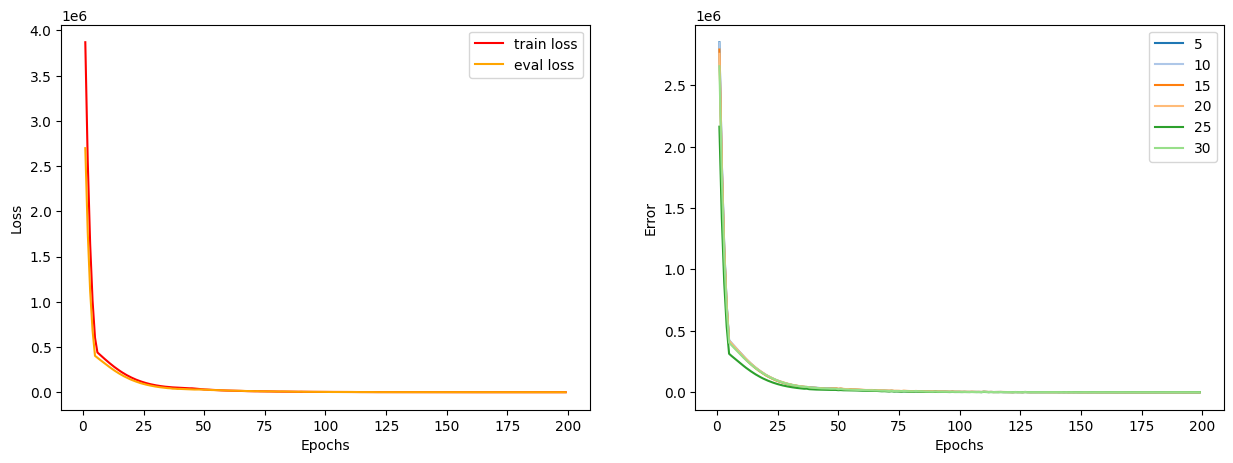

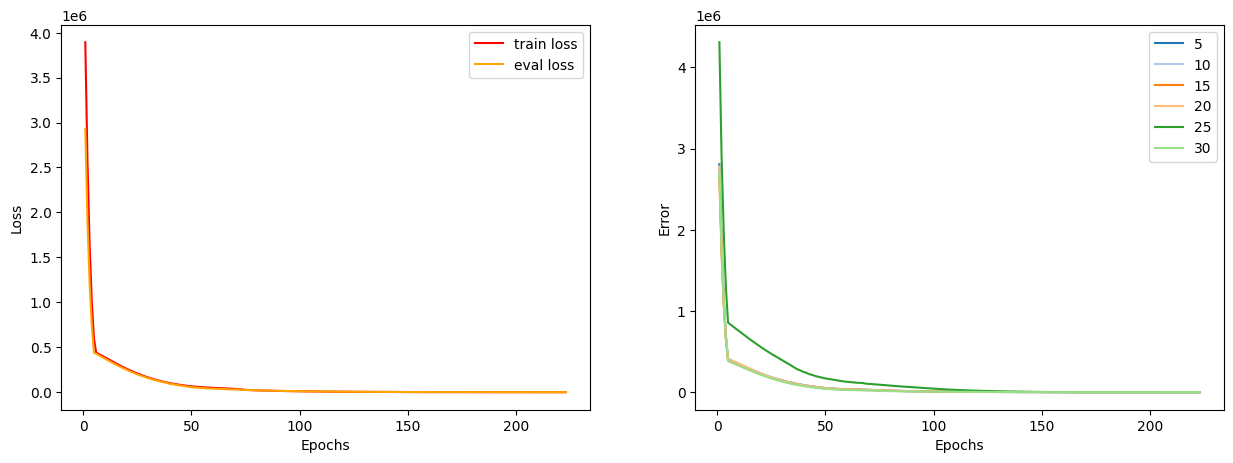

In [ ]:
learning_rates = [0.01, 0.005]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    date_time_ = str(date_time).replace("/", "_")
    mamba_config = {'d_model': 8, 'n_layer': 2, 'd_state': 16, 'expand': 2, 'd_conv': 4, 'model_random_state': 42}
    model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
    training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam',
                       'optimizer_parameter': {'lr': lr}, \
                       'criterion': nn.MSELoss(), 'n_epochs': 600, 'early_stopping': 8, 'evaluation_time': 3,
                       'delta': 0.04, \
                       'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30], \
                       'verbose': True, 'device': device, 'continued': False, 'run': 1}
    training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
    # for bs in batch_sizes:
    #   for l in layers:
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'],
                     mamba_config['d_conv'])
    mamba_model = Mamba(args)

    all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
    all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

    training_mamba = Training(mamba_model, training_config)
    training_mamba.train(all_train_batches, all_val_batches)  #end of training loads the best model

    # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
    #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
    #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
    #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
    exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]),
                                       int(training_mamba.best_results[10]), int(training_mamba.best_results[20]), \
                                       lr, training_config['batch_size'], mamba_config['n_layer'],
                                       mamba_config['d_state'], \
                                       training_config['model_path'], test_filenames, mamba_config.copy(),
                                       training_config.copy(), \
                                       training_mamba.train_loss_history, training_mamba.eval_loss_history,
                                       training_mamba.eval_history, training_mamba.best_results]
    plot_training_summary(training_mamba)
    # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
    #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/02/2024, 15:09:14",13130,14304,13532,0.1,16,1,16,./Models/mamba_model_uav_dm8nl1ds16dc4rs42bs16...,"[VIS_uav_20231117-18018_20231117-094544.json, ...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[3871983.6104525863, 2559687.9504310344, 16377...","[2652382.43515625, 1745260.2015625, 1111765.59...","{5: [tensor(2836152.5000), tensor(1861042.7500...","{5: tensor(13130.5254), 10: tensor(14304.2178)..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_p_' + samples_config['subfolder'] + date_time_

with open(results_path, 'wb') as f:
    pickle.dump(exp_record, f)

In [ ]:
# learning_rates = [0.1, 0.05, 0.01]
learning_rates = [0.05]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    mamba_config = {'d_model': 8, 'n_layer': 1, 'd_state': 16, 'expand': 2, 'd_conv': 4, 'model_random_state': 42}
    model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
    training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam',
                       'optimizer_parameter': {'lr': lr}, \
                       'criterion': nn.MSELoss(), 'n_epochs': 400, 'early_stopping': 5, 'evaluation_time': 3,
                       'delta': 0.04, \
                       'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30], \
                       'verbose': True, 'device': device, 'continued': False, 'run': 1}
    training_config['model_path'] = model_path + conf2str(mamba_config, training_config)
    # for bs in batch_sizes:
    #   for l in layers:
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'],
                     mamba_config['d_conv'])
    mamba_model = Mamba(args)

    all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
    all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

    training_mamba = Training(mamba_model, training_config)
    training_mamba.train(all_train_batches, all_val_batches)  #end of training loads the best model

    exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]),
                                       int(training_mamba.best_results[10]), int(training_mamba.best_results[20]), \
                                       training_config['optimizer_parameter']['lr'], training_config['batch_size'],
                                       mamba_config['n_layer'], mamba_config['d_state'], \
                                       training_config['model_path'], test_filenames, mamba_config.copy(),
                                       training_config.copy(), \
                                       training_mamba.train_loss_history, training_mamba.eval_loss_history,
                                       training_mamba.eval_history, training_mamba.best_results]

    plot_training_summary(training_mamba)
    # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
    #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]